# Enunciado

## Práctica final del módulo de Deep Learning

### Objetivo

El objetivo de la práctica final del módulo de Deep Learning consiste en solucionar un problema del mundo real usando las técnicas vistas en clase. En concreto, lo que se pretende es predecir el precio de habitaciones de AirBnb utilizando para ello todas las características disponibles en el dataset.

Mi consejo personal es que se comience con el dataset que se usó para la práctica del módulo de Machine Learning, y que posteriormente se incorpore nuevas características, como por ejemplo, imágenes o descripciones.

El propósito final no es tener un sistema con una precisión altísima, sino uno que combine distintos tipos de entrada (numéricas, texto, imágenes…) y, MUY IMPORTANTE, que se explique cómo se ha hecho.

En el siguiente enlace hay un ejemplo de cómo se pueden combinar distintos tipos de características con una red neuronal:

https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

El conjunto de datos escogido es [éste](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets), extraído de Airbnb mediante técnicas de scraping.

Dentro de las opciones recomiendo utilizar el extract (“Only the 14780 selected records”), ya que minimiza el tiempo de ejecución y evita problemas de memoria en equipos con menos prestaciones.

### Tarea

Implementar un algoritmo predictivo que sea capaz de estimar el precio de las habitaciones utilizando para ello datos de distintos tipos y técnicas de Deep Learning (redes neuronales profundas).

Criterios de corrección:

* Características utilizadas como input del modelo
* Arquitecturas probadas y experimentos realizados
* Procesamiento de los datos para adecuarlos al modelo
* Explicación de los pasos realizados
* Limpieza del código

Tener en cuenta que se valorará, más que la precisión, la explicación de por qué se ha optado por utilizar una arquitectura u otra y las decisiones tomadas.

### Modo de entrega

El método de entrega deberá ser mediante Google Colab preferiblemente, o en un repositorio de gitlab de no ser posible utilizar Colab. De nuevo, lo importante no es el código, si no que se explique lo que se ha hecho y por qué.

# 0.- Configuración

## Variables, cambiar para modificar detalles

In [1]:
import os
import gc
import platform
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2

# Sistema operativvo
sistema = platform.system()

# Random seed
seed = 1987
np.random.seed(seed)

# descargar_dataset = True para descargar el dataset
descargar_dataset = False

# descargar_imagenes = True para descargar las imágenes
descargar_imagenes = False

# plot de la matriz de correlación (tarda debido al número elevado de características)
visualize_corr_matrix = False

# Buscar al mejor modelo mlp (Tarda un poco , si es false carga los pesos del modelo previamente guardado)
find_best_estimator = False

# El formateo de imágenes conlleva gasto de Ram, poner en False para cargar desde archivo
save_formated_images = False

# Buscar al mejor modelo cnn
find_best_estimator_cnn = False

# Buscar al mejor modelo cnn+mpl
find_best_estimator_mix = False

# Path de Drive (Para mi Colab)
# path_drive = "/content/drive/MyDrive/Practica Deep Learning"
path_drive = "./"

# Working Dir
os.chdir(path_drive)
print("Estamos en {}".format(sistema))
print(os.getcwd())

Estamos en Windows
H:\Práctica de Deep Learning


## Utilidades

### Decorator

In [2]:
# Para medir el tiempo de una función
from functools import wraps, partial
import timeit
import time

def total_time(f = None):
    def wrapping_f(f):
        @wraps(f)
        def wrapper(*args, **kwargs):
            start = time.time()
            result = f(*args, **kwargs)
            print("Tiempo total: {} s".format(time.time() - start))
            return result
        return wrapper
    if f:
        return wrapping_f(f)
    return wrapping_f

### Liberar memoria

In [3]:
def Liberando_memoria(vars_checkpoint, undeleted_vars=[]):
    # Limpiamos variables creadas nuevas que no usaremos
    new_vars = set(locals().keys()).difference(vars_checkpoint)
    for v in undeleted_vars:
        if v in new_vars:
            new_vars.remove(v)
    if 'undeleted_vars' in new_vars:
        new_vars.remove('undeleted_vars')
    for obj in new_vars:
        if not obj.startswith("__"):
            del globals()[obj]
    gc.collect()
    return set(locals().keys()) # nuevo checkpoint

In [4]:
# Procedimiento para ir liberando memoria sobrante
vars_checkpoint = set(locals().keys())

# 1.- Dataset (AirBnB)

## 1.1.- Descargando el Dataset

Descargamos el dataset de Airbnb originados con anteiroridad mediante scrapping

In [5]:
import wget

# Variables
url = "https://public.opendatasoft.com/explore/dataset/airbnb-listings/download/?format=csv&disjunctive.host_verifications=true&disjunctive.amenities=true&disjunctive.features=true&q=Madrid&timezone=Europe/Berlin&lang=en&use_labels_for_header=true&csv_separator=%3B"
dataset_dir = "./Dataset"
filename = "airbnb-listings.csv"
dataset_path = dataset_dir + "/" + filename

if descargar_dataset:
    # Creo carpeta si no existe
    if not os.path.isdir(dataset_dir):
        os.mkdir(dataset_dir)
    # Descargo el archivo (si existe lo reescribo)
    if os.path.exists(dataset_path):
        os.remove(dataset_path)
    _ = wget.download(url, out=dataset_path)

In [6]:
%%bash
ls -ll "./Dataset/"

total 59080
-rwxrwxrwx 1 tonyzetag tonyzetag 60495800 Jan 27 03:49 airbnb-listings.csv


## 1.2.- Importando el Dataset

### 1.2.1.- Importando los datos (csv)

In [7]:
# Leemos los datos desde csv (separación mediante ';', Index = ID)
data = pd.read_csv(dataset_path, sep = ';', index_col='ID')

Comprobamos los datos importados y que todo esté en orden

In [8]:
# Mostramos las 5 primeras filas
data.head(5)

,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,Notes,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
ID,,,,,,,,,,,,,,,,,,,,,
15141125,https://www.airbnb.com/rooms/15141125,20170407214119,2017-04-08,Panoramic charming studio!,"Charming bright and cosy studio in ""El Rastro""...",It's a bright and cosy studio located in the h...,"Charming bright and cosy studio in ""El Rastro""...",none,The studio is located in the remarkable neighb...,NaN,...,10.0,10.0,10.0,NaN,NaN,moderate,2.0,5.11,"40.40745268477803,-3.7079954754432634","Host Is Superhost,Host Has Profile Pic,Host Id..."
9470166,https://www.airbnb.com/rooms/9470166,20170407214119,2017-04-08,Comfortable penthouse in the center,"In the center, recently remodeled, comfortable...",Quiet and comfortable space where you can rela...,"In the center, recently remodeled, comfortable...",none,It belongs to the district center of Madrid wh...,A la misma distancia en tiempo podrás acceder ...,...,9.0,9.0,8.0,NaN,NaN,strict,13.0,5.88,"40.40831556101927,-3.705006385704201","Host Has Profile Pic,Host Identity Verified,Re..."
17444981,https://www.airbnb.com/rooms/17444981,20170407214119,2017-04-08,Cosy Apartment SOL/LA LATINA,Nice apartment near Sol and La Latina. Perfect...,Is a really cosy apartment with the best locat...,Nice apartment near Sol and La Latina. Perfect...,none,"La Latina is well known by El Rastro, the most...","Airport transfer for maximum 4 people, 30€ one...",...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,6.18,"40.413722014584295,-3.7068231186536718","Host Has Profile Pic,Host Identity Verified,Re..."
3284565,https://www.airbnb.com/rooms/3284565,20170407214119,2017-04-08,Alquiler Estudio Nuevo Madrid,"Alquilo estudio en el centro de Madrid , total...",NaN,"Alquilo estudio en el centro de Madrid , total...",none,NaN,NaN,...,10.0,9.0,9.0,NaN,NaN,strict,3.0,0.19,"40.411263372718054,-3.6973054373712886","Host Has Profile Pic,Host Identity Verified,Is..."
499911,https://www.airbnb.com/rooms/499911,20170407214119,2017-04-08,2 bedroom apartment downtown Madrid,NaN,Bright and airy apartment in Central Madrid re...,Bright and airy apartment in Central Madrid re...,none,NaN,NaN,...,10.0,10.0,10.0,NaN,NaN,strict,1.0,1.39,"40.41255625665078,-3.701155364799422","Host Is Superhost,Host Has Profile Pic,Host Id..."


In [9]:
# Comprobamos la dimensión de los datos importados
data.shape

(14780, 88)

In [10]:
# Comprobamos los nombres de las columnas
data.columns

Index(['Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary', 'Space',
       'Description', 'Experiences Offered', 'Neighborhood Overview', 'Notes',
       'Transit', 'Access', 'Interaction', 'House Rules', 'Thumbnail Url',
       'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL',
       'Host Name', 'Host Since', 'Host Location', 'Host About',
       'Host Response Time', 'Host Response Rate', 'Host Acceptance Rate',
       'Host Thumbnail Url', 'Host Picture Url', 'Host Neighbourhood',
       'Host Listings Count', 'Host Total Listings Count',
       'Host Verifications', 'Street', 'Neighbourhood',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City',
       'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
       'Country', 'Latitude', 'Longitude', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Square Feet', 'Price', 'Weekly Price', 'Monthly Price',
  

### 1.2.2.- Importando las imágenes del dataset

In [11]:
# Lo primero es crear una lista con el index, y las URL de las imágenes (Solamente lo haremos con la columna 'Thumbnail Url'
images_paths = [[i, img_url] for i, img_url in enumerate(data['Thumbnail Url'])]

# Comprobemos que tenemos
for i in images_paths[:10]:
    print(i) 
print('\n', len(images_paths))

[0, 'https://a0.muscache.com/im/pictures/d1a2212d-c13b-45ec-b1f7-2f0b6dc53137.jpg?aki_policy=small']
[1, 'https://a0.muscache.com/im/pictures/3eb59287-8b7c-42ff-95c7-8d00cbfd4c55.jpg?aki_policy=small']
[2, 'https://a0.muscache.com/im/pictures/de09fac7-9db7-4d02-a34e-9cfc61aef986.jpg?aki_policy=small']
[3, nan]
[4, 'https://a0.muscache.com/im/pictures/6136974/57d1a7e1_original.jpg?aki_policy=small']
[5, nan]
[6, nan]
[7, 'https://a0.muscache.com/im/pictures/cf350e03-c9ec-4194-b58f-a884c0a349e8.jpg?aki_policy=small']
[8, nan]
[9, nan]

 14780


Vamos a definir la función get_image(data_url, target_size=(224, 224)) que descarga las imágenes y las devuelve con el índice donde guardarlas

In [12]:
if descargar_imagenes:
    
    # Import library
    import imageio as io
    from numpy import moveaxis
    import PIL.Image
    
    # Esta función descarga las imágenes y las devuelve con el índice donde guardarlas
    def get_image(data_url, target_size=(224, 224)):
        idx, url = data_url
        try:
            img = io.imread(url)
            
            # Some images may be in black & white. I convert to to RGB as otherwise it generates error
            if img.ndim < 3:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

            # If channels info is in first place, move to last position
            if (img.shape[0] < img.shape[1] ) and (img.shape[0] < img.shape[2]):
                img = moveaxis(img, 0, 2)

            # In case any image is RGBA, take onloy RGB channels
            img = img[...,:3]

            
            img = cv2.resize(img, dsize=target_size)
            return img, idx

        except IOError as err:
            return (None, idx)

Probamos guardar las imagenes

In [13]:
# Tensor en el que se guardará las imágenes
loaded_images = np.zeros((len(images_paths), 224, 224, 3), dtype=np.uint8)

# Tensor para ver que imagenes no fueron guardadas
was_loaded = np.zeros(len(images_paths))

print(loaded_images.shape)

(14780, 224, 224, 3)


In [14]:
#  Dejo max_workers=1 por estar en windows
if descargar_imagenes:
    
    # Import library
    import concurrent
    from tqdm import tqdm
    
    # Creating pool to load images. By default, it uses as much cores as your machine has
    if sistema == "Windows":
        executor = concurrent.futures.ThreadPoolExecutor()
    else:
        executor = concurrent.futures.ProcessPoolExecutor()
        
    with executor:
        for (img, idx) in tqdm(executor.map(get_image, images_paths), total=len(images_paths)):

            # Loading the images
            if img is not None:
                loaded_images[idx] = img
                was_loaded[idx] = 1
            else:
                was_loaded[idx] = 0

    print('Finished!')
    print(f'Number of images loaded: {sum(was_loaded)}/{len(images_paths)}')

In [15]:
# Variables
image_dir = "./Images"
images_filename = "images.npy"
was_loaded_filename = "was_loaded.npy"
images_path = "/".join([image_dir, images_filename])
was_loaded_path = "/".join([image_dir, was_loaded_filename])


if descargar_imagenes:
    # Creo carpeta si no existe
    if not os.path.isdir(image_dir):
        os.mkdir(image_dir)
    # Descargo el archivo (Variable numpy)
    np.save('./Images/images.npy', loaded_images)
    np.save('./Images/was_loaded.npy', was_loaded)

In [16]:
%%bash
ls -lah './images/images.npy' './images/was_loaded.npy'

-rwxrwxrwx 1 tonyzetag tonyzetag 2.1G Jan 27 03:53 ./images/images.npy
-rwxrwxrwx 1 tonyzetag tonyzetag 116K Jan 27 03:53 ./images/was_loaded.npy


#### Carga de imágenes

In [17]:
loaded_images = np.load(images_path)
was_loaded = np.load(was_loaded_path)
print(loaded_images.shape)
print(was_loaded.shape)

(14780, 224, 224, 3)
(14780,)


#### Análisis de las imagenes

Primero, vamos a comprobar cuantas imágenes tenemos, que porcentaje es del dataset

In [18]:
print("Tenemos un total de {} cargadas".format(int(was_loaded.sum())))
print("Este es un {:.2f}% del dataset total".format(100 * int(was_loaded.sum()) / len(was_loaded)))

Tenemos un total de 11926 cargadas
Este es un 80.69% del dataset total


Es un buen porcentaje, tenemos imágenes suficientes, también podemos visualizar alguna imagen, para ver que esté correcto.

In [19]:
def plot_random_image(images, was_loaded):
    idx = np.random.randint(low=0, high=len(images))
    plt.title ("Imagen - Index: {} - Loaded: {}".format(idx, bool(was_loaded[idx])))
    plt.imshow(images[idx])

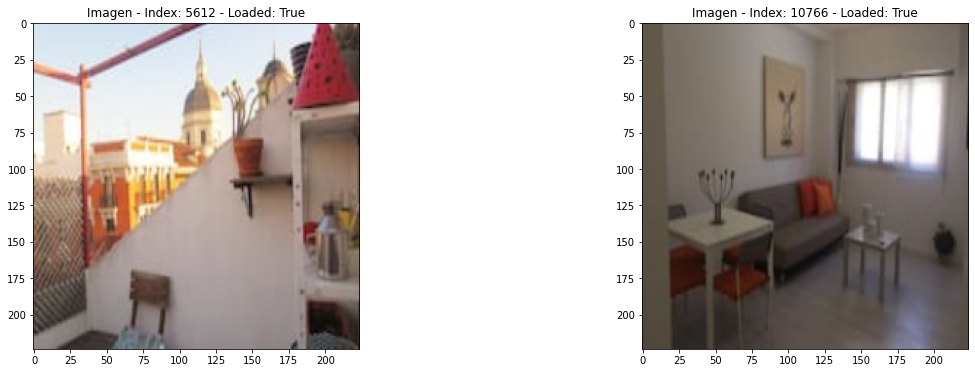

In [20]:
# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 2, 1)
plot_random_image(loaded_images, was_loaded)
fig.add_subplot(1, 2, 2)
plot_random_image(loaded_images, was_loaded)

# Muestro en pantalla
plt.show()

#### Por último, vamos a pasar el tensor de imágenes a dataset y ordenarlo por ID

In [21]:
# A partir de ahora, data es la carga original, df es nuestro dataframe en el que trabajaremos
df = data.copy()

In [22]:
# Creamos df2 que une el ID, la imagen, y si está cargado o no
df2 = pd.DataFrame(
    [(df.index.values[idx], was_loaded[idx], image) for idx, image in enumerate(loaded_images)],
    columns=["ID", "Image Loaded", "Image"]).set_index("ID")

df2.head()

,Image Loaded,Image
ID,,
15141125,1.0,"[[[89, 52, 25], [85, 48, 21], [88, 51, 22], [9..."
9470166,1.0,"[[[69, 60, 55], [70, 61, 56], [71, 62, 57], [7..."
17444981,1.0,"[[[90, 72, 50], [90, 72, 50], [92, 74, 52], [9..."
3284565,0.0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
499911,1.0,"[[[149, 169, 158], [153, 173, 162], [161, 177,..."


In [23]:
# Unimos los df y ya tenemos nuestro dataset completo para trabajar con el
df = pd.merge(df, df2, on='ID', how='inner')

In [24]:
# Vemos las dimensiones
df.shape

(14780, 90)

In [25]:
# Para pasar a tipo booleano
df['Image Loaded'] = df['Image Loaded']==df['Image Loaded'].max()
df['Image Loaded'].head()

ID
15141125     True
9470166      True
17444981     True
3284565     False
499911       True
Name: Image Loaded, dtype: bool

In [26]:
# Libero memoria
vars_checkpoint = Liberando_memoria(vars_checkpoint, ['df'])

# 2.- Parte de Machine Learning

## 2.1.- División de los datos (Train - Test)

Para evitar problemas de manipulación de datos, primero vamos a dividir nuestros datos en train - test, vamos a usar 80% train - 20% test

Para ello vamos a usar como estrategia (stratify) la distribución en si la imágen está cargada o no, para distribuir bien los datos

In [27]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    df, test_size = 0.20, 
    random_state=3134, 
    shuffle=True, 
    stratify=df["Image Loaded"])

In [28]:
[train["Image Loaded"].describe(), test["Image Loaded"].describe()]

[count     11824
 unique        2
 top        True
 freq       9541
 Name: Image Loaded, dtype: object,
 count     2956
 unique       2
 top       True
 freq      2385
 Name: Image Loaded, dtype: object]

In [29]:
# Recuento de datos
print("Train: Tenemos {} muestras".format(train.shape[0]))
print("Test: Tenemos {} muestras".format(test.shape[0]))

Train: Tenemos 11824 muestras
Test: Tenemos 2956 muestras


In [30]:
# Por estética y por practicidad, voy a poner la variable target al principio
cols_sorted = train.columns.to_list()
cols_sorted.remove('Price')
cols_sorted.insert(0, 'Price')
new_train = train[cols_sorted]
del train
train = new_train
del new_train

## 2.2.- Eliminación de características sin valor para nuestro objetivo

In [31]:
# Diccionario de todas las columnas y sus respectivos tipos
cols_dtype = {col: train[col].dtype for col in train.columns}
cols_dtype

{'Price': dtype('float64'),
 'Listing Url': dtype('O'),
 'Scrape ID': dtype('int64'),
 'Last Scraped': dtype('O'),
 'Name': dtype('O'),
 'Summary': dtype('O'),
 'Space': dtype('O'),
 'Description': dtype('O'),
 'Experiences Offered': dtype('O'),
 'Neighborhood Overview': dtype('O'),
 'Notes': dtype('O'),
 'Transit': dtype('O'),
 'Access': dtype('O'),
 'Interaction': dtype('O'),
 'House Rules': dtype('O'),
 'Thumbnail Url': dtype('O'),
 'Medium Url': dtype('O'),
 'Picture Url': dtype('O'),
 'XL Picture Url': dtype('O'),
 'Host ID': dtype('int64'),
 'Host URL': dtype('O'),
 'Host Name': dtype('O'),
 'Host Since': dtype('O'),
 'Host Location': dtype('O'),
 'Host About': dtype('O'),
 'Host Response Time': dtype('O'),
 'Host Response Rate': dtype('float64'),
 'Host Acceptance Rate': dtype('O'),
 'Host Thumbnail Url': dtype('O'),
 'Host Picture Url': dtype('O'),
 'Host Neighbourhood': dtype('O'),
 'Host Listings Count': dtype('float64'),
 'Host Total Listings Count': dtype('float64'),
 'Host

En un primer vistazo se puede observar que hay columnas que no aportan valor a nuestro objetivo vamos a eliminarlas directamente ya que estas no serán útil, esto se va a realizar en nuestro set de datos de entrenamiento

In [32]:
cols_to_del = set() # Variable de características que se van a eliminar (total)

### 2.2.1.- Texto como metadatos sin valor para nuestro objetivo

In [33]:
# Busqueda de caracteristicas
substrings = ('url','scrape')
for substring in substrings:
    [cols_to_del.add(s) for s in train.columns if substring in s.lower()]

# Conteo de características
print("número de características a eliminar (acumulado): {}".format(len(cols_to_del)))

número de características a eliminar (acumulado): 11


### 2.2.2.- Características relacionadas pero sin valor para nuestro modelo.

In [34]:
# Columnas a analizar
cols = {'Name', 'Host Name', 'Description', 'Interaction', 'Summary', 'Space', 'Experiences Offered', 
         'Neighborhood Overview', 'Notes', 'Transit', 'Access', 
         'House Rules', 'Host ID', 'Host Since', 'Host Location',
         'Host About', 'Host Neighbourhood', 'Host Listings Count',
         'Host Total Listings Count', 'Host Verifications', 'Amenities', 
         'Calendar Updated', 'Has Availability', 'First Review', 'Last Review',
         'License', 'Jurisdiction Names', 'Cancellation Policy', 'Features'}

* **Criterio 1** - De las columnas seleccionadas, eliminar las columnas con mas de 15% valores nulos

In [35]:
#Columnas con mas de 15% valores nulos
with_nans = 100 * df[cols].isnull().sum() / df.shape[0] > 20
with_nans = set(with_nans.index[with_nans])

C:\Users\tonyz\AppData\Local\Temp\ipykernel_4724\3011635614.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  with_nans = 100 * df[cols].isnull().sum() / df.shape[0] > 20


In [36]:
for col in with_nans:
    print("{:<25}\t{:.2f}%".format(col, 100 * df[col].isnull().sum() / df.shape[0]))

License                  	97.64%
Neighborhood Overview    	38.20%
Host About               	35.46%
House Rules              	34.92%
Access                   	43.72%
Space                    	26.33%
Has Availability         	99.92%
Transit                  	38.66%
Jurisdiction Names       	98.46%
Notes                    	61.81%
Interaction              	44.33%
First Review             	21.39%
Last Review              	21.40%
Host Neighbourhood       	26.22%


In [37]:
cols = set(cols).difference(with_nans)
cols_to_del = set(cols_to_del).union(with_nans)

In [38]:
for col in cols:
    print("{:<25}\t{:.2f}%".format(col, 100 * df[col].isnull().sum() / df.shape[0]))

Host Name                	0.02%
Host Verifications       	0.04%
Host Since               	0.02%
Summary                  	4.00%
Host Listings Count      	0.02%
Description              	0.04%
Host Location            	0.29%
Amenities                	1.15%
Host Total Listings Count	0.02%
Features                 	0.01%
Host ID                  	0.00%
Name                     	0.01%
Calendar Updated         	0.00%
Experiences Offered      	0.00%
Cancellation Policy      	0.00%


In [39]:
print("número de características a eliminar (acumulado): {}".format(len(cols_to_del)))

número de características a eliminar (acumulado): 25


In [40]:
# Analizemos columna a columna, de las que quedan
for col in cols:
    print(df[col].head())
    print("total nulls: {}, ({:.2f}%)".format(
        df[col].isnull().sum(), 
        100 * df[col].isnull().sum() / df.shape[0]))
    print('\n')

ID
15141125          Marina
9470166            Jorge
17444981    Luis Enrique
3284565            Laura
499911              Joel
Name: Host Name, dtype: object
total nulls: 3, (0.02%)


ID
15141125     email,phone,facebook,reviews,jumio,government_id
9470166                             email,phone,reviews,jumio
17444981    email,phone,facebook,reviews,jumio,offline_gov...
3284565               email,phone,reviews,jumio,government_id
499911                     email,phone,facebook,reviews,jumio
Name: Host Verifications, dtype: object
total nulls: 6, (0.04%)


ID
15141125    2016-09-20
9470166     2013-11-08
17444981    2017-02-25
3284565     2012-03-09
499911      2012-05-26
Name: Host Since, dtype: object
total nulls: 3, (0.02%)


ID
15141125    Charming bright and cosy studio in "El Rastro"...
9470166     In the center, recently remodeled, comfortable...
17444981    Nice apartment near Sol and La Latina. Perfect...
3284565     Alquilo estudio en el centro de Madrid , total...
499911   

* Las siguientes columnas se van a eliminar por no aportar valor al modelo

In [41]:
without_value = {"Name", "Host Name", "Experiences Offered", 
                "Host ID", "Host Since", "Host Location",
                "Host Listings Count", "Host Total Listings Count",
                "Calendar Updated"}

cols_to_del = cols_to_del.union(without_value)
cols = cols.difference(without_value)

# Conteo de características
print("número de características a eliminar (acumulado): {}".format(len(cols_to_del)))

número de características a eliminar (acumulado): 34


In [42]:
# Analizemos columna a columna, de las que quedan
for col in cols:
    print(df[col].head())
    print("total nulls: {}, ({:.2f}%)".format(
        df[col].isnull().sum(), 
        100 * df[col].isnull().sum() / df.shape[0]))
    print('\n')

ID
15141125     email,phone,facebook,reviews,jumio,government_id
9470166                             email,phone,reviews,jumio
17444981    email,phone,facebook,reviews,jumio,offline_gov...
3284565               email,phone,reviews,jumio,government_id
499911                     email,phone,facebook,reviews,jumio
Name: Host Verifications, dtype: object
total nulls: 6, (0.04%)


ID
15141125    Charming bright and cosy studio in "El Rastro"...
9470166     In the center, recently remodeled, comfortable...
17444981    Nice apartment near Sol and La Latina. Perfect...
3284565     Alquilo estudio en el centro de Madrid , total...
499911                                                    NaN
Name: Summary, dtype: object
total nulls: 591, (4.00%)


ID
15141125    Charming bright and cosy studio in "El Rastro"...
9470166     In the center, recently remodeled, comfortable...
17444981    Nice apartment near Sol and La Latina. Perfect...
3284565     Alquilo estudio en el centro de Madrid , total...


Cosas que quedan pendiente y se puede hacer en un futuro:
* **Cancellation Policy**: análisis mediante categorías
* **Host Verifications**: análisis por palabras
* **Summary**: análisis por sentimiento
* **Amenities**: análisis por palabras
* **Description**: análisis por sentimiento
* **Features**: análisis por palabras

### 2.2.3.- Características que no aportan información nueva (linealmente dependientes de nuestra variable target)

In [43]:
# Busqueda de caracteristicas
substring = 'price'
[cols_to_del.add(s) for s in train.columns if substring in s.lower()]
cols_to_del.remove('Price')

# Conteo de características
print("número de características a eliminar (acumulado): {}".format(len(cols_to_del)))

número de características a eliminar (acumulado): 36


### 2.2.4.- Eliminamos las columnas del DataFrame

In [44]:
# Eliminamos las columnas con drop, axis=1 para columnas
train = train.drop(cols_to_del, axis=1)

# Características eliminadas
print("Se ha eliminado {}, nos quedan {}".format(len(cols_to_del), len(train.columns)))

Se ha eliminado 36, nos quedan 54


### 2.2.5.- Arreglando tipos

In [45]:
# dtypes, muestra los tipos de cada característica
train.dtypes

Price                             float64
Summary                            object
Description                        object
Host Response Time                 object
Host Response Rate                float64
Host Acceptance Rate               object
Host Verifications                 object
Street                             object
Neighbourhood                      object
Neighbourhood Cleansed             object
Neighbourhood Group Cleansed       object
City                               object
State                              object
Zipcode                            object
Market                             object
Smart Location                     object
Country Code                       object
Country                            object
Latitude                          float64
Longitude                         float64
Property Type                      object
Room Type                          object
Accommodates                        int64
Bathrooms                         

In [46]:
# Características que deberían ser categóricas
cols_categoricals = ['Host Response Time', 'Host Acceptance Rate', 'Street', 'Neighbourhood', 
                     'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed',
                     'City', 'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
                     'Country', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']
for col in cols_categoricals:
    train[col] = train[col].astype('category')

In [47]:
# Situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 11824 filas y 54 columnas


## 2.3.- Análisis exploratorio

### 2.3.1.- Análisis de características (estadística y visualización)

In [48]:
# Primero vamos a examinar la variable target
train['Price'].isna().value_counts()

False    11810
True        14
Name: Price, dtype: int64

In [49]:
# Tenemos nan values en Price, vamos a eliminarlo
train = train[~train['Price'].isna()]

Aún tenemos muchas características, vamos a investigar a ver que podemos hacer con ellas, el objetivo es eliminar las que contengan poca información, o sea redundante, vamos a empezar mirando las variables categóricas

#### Variables categóricas

In [50]:
# Mi histograma, será de ayuda para analizar características
def my_hist(df, colname):
    '''
    df: pandas.DataFrame
    colname: String de la columna a visualizar
    '''
    
    # Variables
    labels = df[colname][~df[colname].isna()].value_counts().index.values
    values = df[colname][~df[colname].isna()].value_counts().values
    limit = 10 if len(labels) > 15 else len(labels)
    
    # Nuestro datos (con un límite de 10 máximo)
    data = [labels[0:limit], values[0:limit]]
    
    # Uso de Matplotlib
    plt.bar(data[0], data[1])
    plt.title (colname)
    plt.xticks(rotation=45)

* **Análisis de datos del anfitrión**

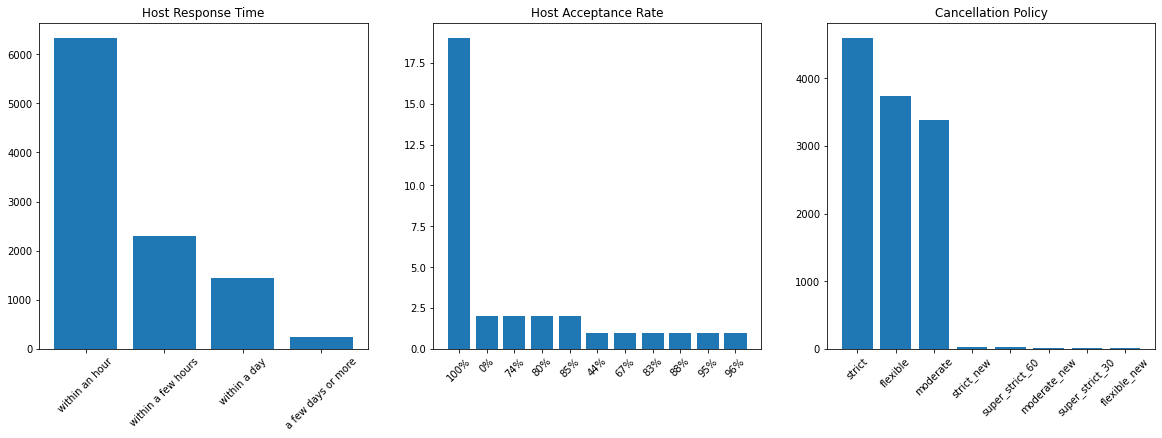

In [51]:
# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Host Response Time')
fig.add_subplot(1, 3, 2)
my_hist(train, 'Host Acceptance Rate')
fig.add_subplot(1, 3, 3)
my_hist(train, 'Cancellation Policy')

# Muestro en pantalla
plt.show()

In [52]:
# 'Host Acceptance Rate' tiene muy pocas instancias podemos verlo aquí, esta característica puede descartarse
train['Host Acceptance Rate'].describe()

count       33
unique      11
top       100%
freq        19
Name: Host Acceptance Rate, dtype: object

In [53]:
# Elimino dicha característica
train = train.drop('Host Acceptance Rate', axis=1)

# Situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 11810 filas y 53 columnas


* **Análisis de datos de la propiedad**

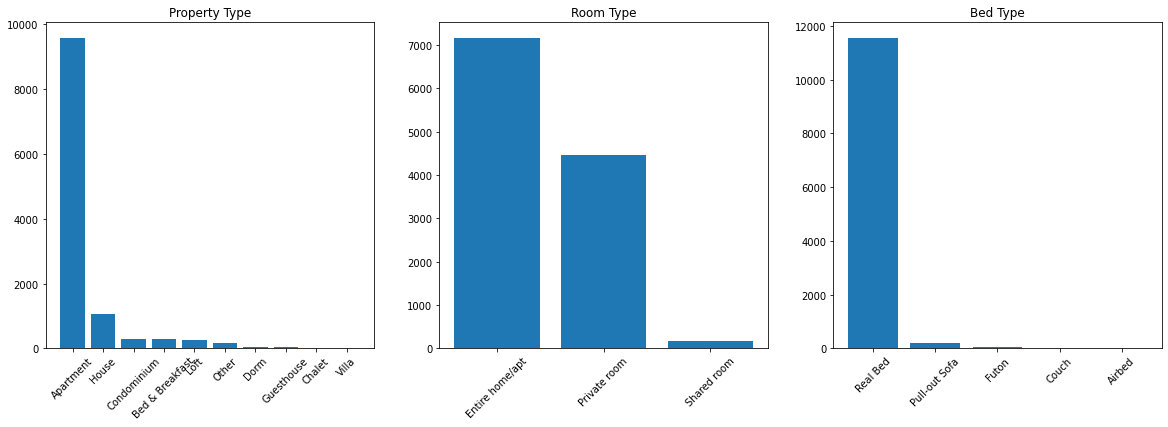

In [54]:
# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Property Type')
fig.add_subplot(1, 3, 2)
my_hist(train, 'Room Type')
fig.add_subplot(1, 3, 3)
my_hist(train, 'Bed Type')

# Muestro en pantalla
plt.show()

In [55]:
# 'Bed Type' tiene la gran mayoría de instancias como 'real Bed' podemos verlo aquí, así que esta característica podría descartarse
p_c = train['Bed Type'].describe()[3] / train['Bed Type'].describe()[0] * 100
print("El {}% de los datos son {}, que es el valor con mayor frecuencia".format(p_c, train['Bed Type'].describe()[2]))

El 97.87468247248094% de los datos son Real Bed, que es el valor con mayor frecuencia


In [56]:
# Me quedo con las de mayor frecuencia y elimino dicha característica
train = train.loc[train['Bed Type'] == 'Real Bed']
train.drop('Bed Type', axis=1, inplace=True)

# Situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 11559 filas y 52 columnas


In [57]:
# Para 'Property Type' creo que es buena idea realizar una transformación, lo haremos en el punto 3 (Si vale la pena)
p_c = train['Property Type'].describe()[3] / train['Property Type'].describe()[0] * 100
print("El {}% de los datos son {}, que es el valor con mayor frecuencia".format(p_c, train['Property Type'].describe()[2]))

El 81.04507310320962% de los datos son Apartment, que es el valor con mayor frecuencia


* **Análisis de los datos geográficos**

C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


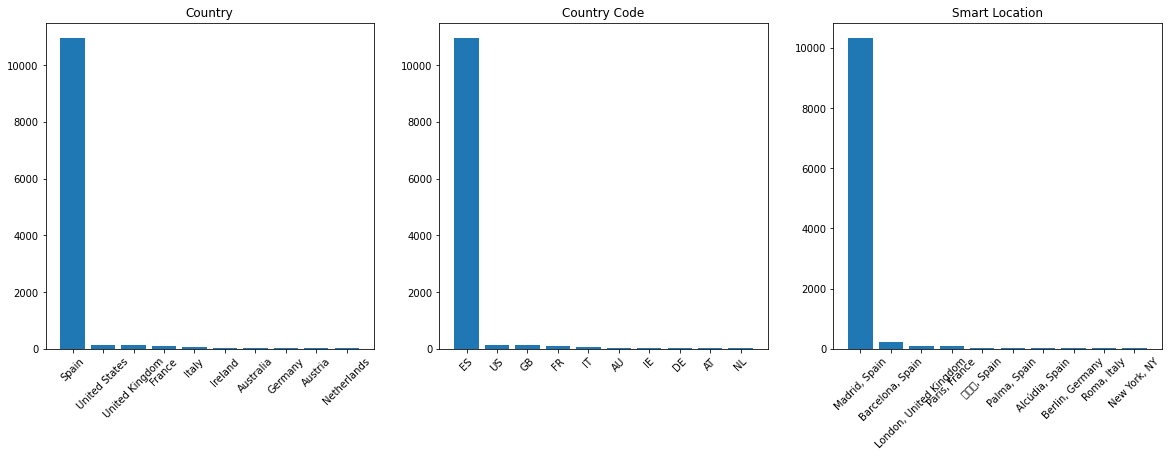

In [58]:
# Vamos a analizar nuestros datos de localización, empezamos por lo mas global, paises

# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Country')
fig.add_subplot(1, 3, 2)
my_hist(train, 'Country Code')
fig.add_subplot(1, 3, 3)
my_hist(train, 'Smart Location')

# Muestro en pantalla
plt.show()

In [59]:
# Podemos ver que la mayoría de los datos son de España, podemos quitar el resto de registros
p_c = train['Country'].describe()[3] / train['Country'].describe()[0] * 100
print("El {}% de los datos son {}, que es el valor con mayor frecuencia".format(p_c, train['Country'].describe()[2]))

El 94.74868068171988% de los datos son Spain, que es el valor con mayor frecuencia


In [60]:
# Me quedo con las de mayor frecuencia y elimino todas las características
train = train.loc[train['Country Code'] == 'ES']
train.drop(['Country', 'Country Code', 'Smart Location'], axis=1, inplace=True)

C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 39532 (\N{CJK UNIFIED IDEOGRAPH-9A6C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24503 (\N{CJK UNIFIED IDEOGRAPH-5FB7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\tonyz\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27835 (\

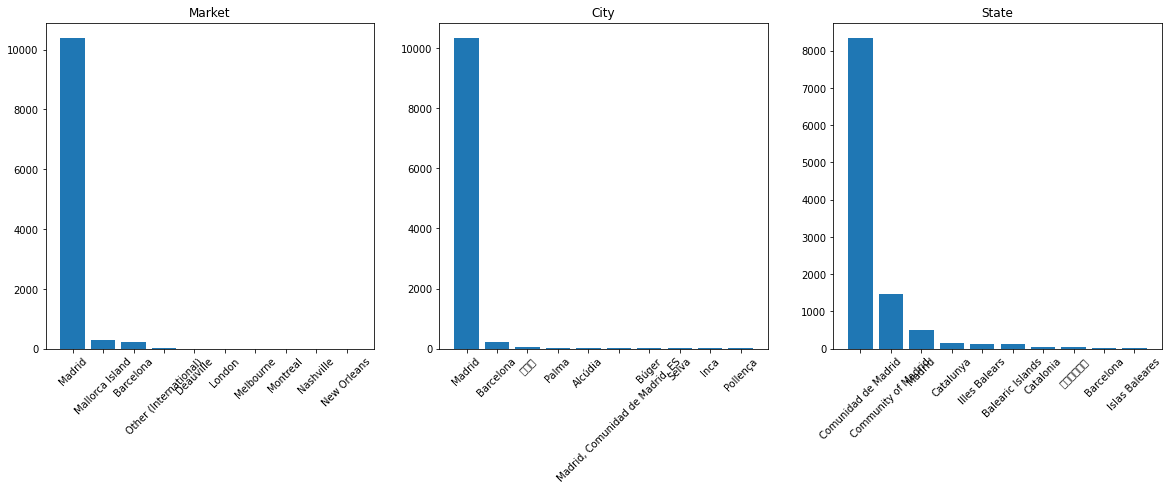

In [61]:
# El siguiente nivel a analizar sería a nivel nacional

# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Market')
fig.add_subplot(1, 3, 2)
my_hist(train, 'City')
fig.add_subplot(1, 3, 3)
my_hist(train, 'State')

# Muestro en pantalla
plt.show()

In [62]:
# Podemos ver que la mayoría de los datos son de Madrid, podemos quitar el resto de registros
p_c = train['City'].describe()[3] / train['City'].describe()[0] * 100
print("El {}% de los datos son {}, que es el valor con mayor frecuencia".format(p_c, train['City'].describe()[2]))

El 94.38253562294483% de los datos son Madrid, que es el valor con mayor frecuencia


In [63]:
# Me quedo con las de mayor frecuencia y elimino todas las características
train = train.loc[train['City'] == 'Madrid']
train.drop(['Market', 'City', 'State'], axis=1, inplace=True)

**Nota**: 
En este caso, parecía haber algunos datos que podrían ser validos (como Comunidad de Madrid)
pero al ser estos un porcentaje tan pequeño se ha optado por descartarlas directamente

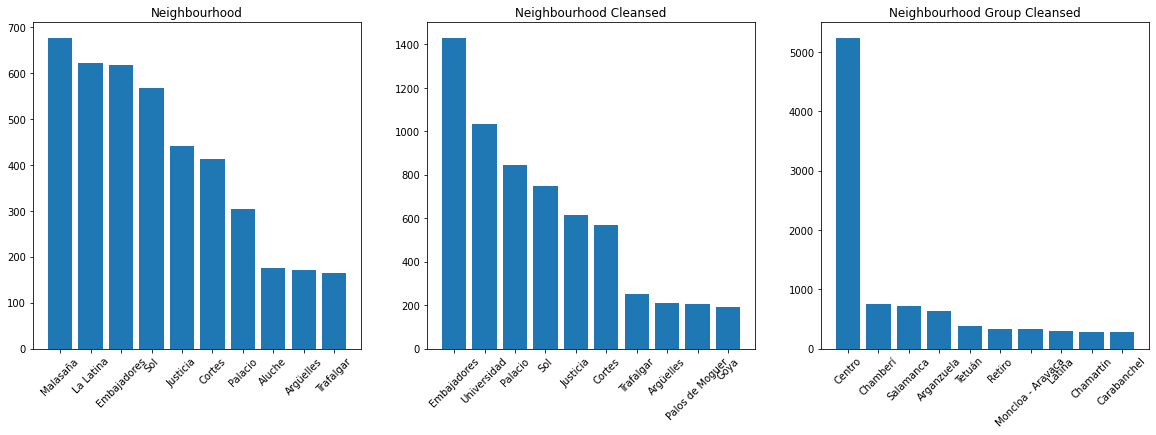

In [64]:
# El siguiente nivel a analizar sería a nivel de distrito o barrio

# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Neighbourhood')
fig.add_subplot(1, 3, 2)
my_hist(train, 'Neighbourhood Cleansed')
fig.add_subplot(1, 3, 3)
my_hist(train, 'Neighbourhood Group Cleansed')

# Muestro en pantalla
plt.show()

In [65]:
# Los datos están distribuidos de forma normal, entremos en más detalle
train[['Neighbourhood','Neighbourhood Cleansed', 'Neighbourhood Group Cleansed']].describe()

,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed
count,6842,10333,10333
unique,65,125,21
top,Malasaña,Embajadores,Centro
freq,676,1429,5237


In [66]:
# A la hora de hacer el modelo, sería inviable tantas variables, así que nos vamos a quedar con el que menos tiene

# Por lo tanto nos quedamos con 'Neighbourhood Group Cleansed'
train.drop(['Neighbourhood', 'Neighbourhood Cleansed'], axis=1, inplace=True)

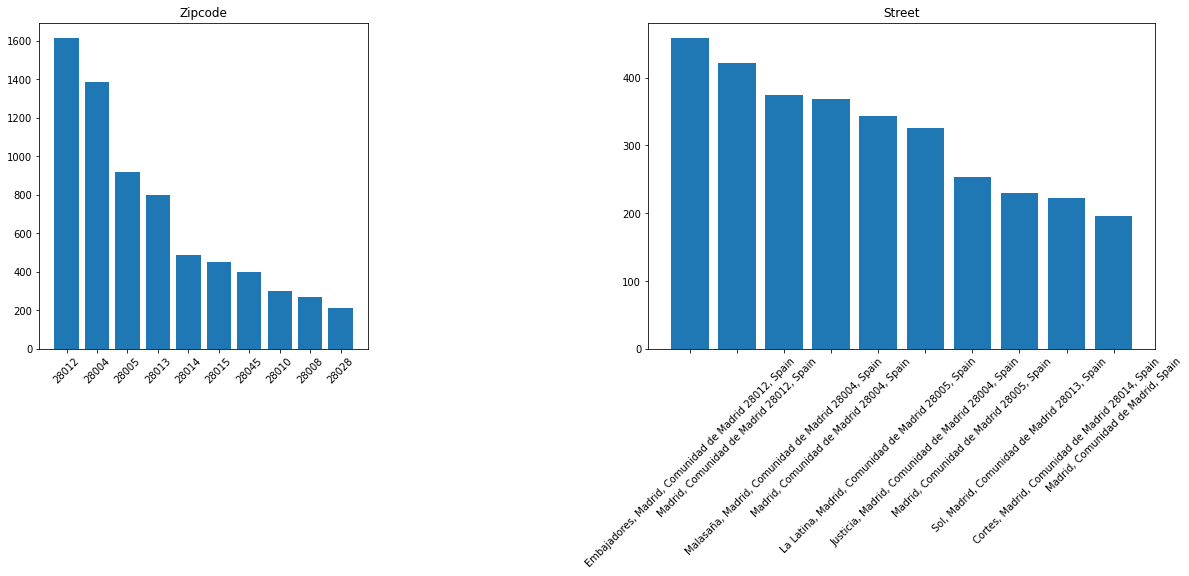

In [67]:
# El siguiente nivel a analizar sería a nivel de código postal y calle

# Tamaño de la figura
fig = plt.figure(figsize=(20,6))

# Subplots
fig.add_subplot(1, 3, 1)
my_hist(train, 'Zipcode')
fig.add_subplot(1, 2, 2)
my_hist(train, 'Street')

# Muestro en pantalla
plt.show()

In [68]:
# Los datos están distribuidos, entremos en más detalle
train[['Zipcode','Street']].describe()

,Zipcode,Street
count,9982,10333
unique,71,604
top,28012,"Embajadores, Madrid, Comunidad de Madrid 28012..."
freq,1612,458


In [69]:
# En este caso podemos ver que las variables son demasiado altas, 
# podemos descartar Street y quizás dejar Zipcode, para realizarle alguna transformación

# Eliminamos Street 
train.drop(['Street'], axis=1, inplace=True)

In [70]:
# Dado que, código postal debería ser de tipo numérico, en este caso parece que hay datos que no cumplen
# los cuáles hacen que se considere object dicha característica, vamos a limpiar dichos datos

# 1.- Los que no son números
c = [not str(row).isdigit() for row in train['Zipcode']]
train['Zipcode'][c] = np.nan

# 2.- rango válido
c = [not (float(row) >= 28000 and float(row) < 29000) for row in train['Zipcode']]
train['Zipcode'][c] = np.nan

# 3.- Arreglamos categories
train['Zipcode'] = train['Zipcode'].cat.remove_unused_categories()

# Nos queda lo siguiente
train['Zipcode'].describe()

count      9971
unique       60
top       28012
freq       1612
Name: Zipcode, dtype: object

In [71]:
# Se me ocurre que dado que tenemos datos de latitud y longitud, podriamos rellenar 
# los datos nulos e introducír el código postal, pero eso sería demasiado y no creo que valiera la pena

In [72]:
# Geolocation no es mas que una combinación en forma de tupla de Latitude y Longitude, así que lo eliminamos
train.drop(['Geolocation'], axis=1, inplace=True)

# Situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 42 columnas


In [73]:
categorical = train.dtypes[train.dtypes == 'category'].index

mean_map = {}
for c in categorical:
    mean = train.groupby(c)['Price'].mean()
    train[c] = train[c].map(mean)
    mean_map[c] = mean
    

train[categorical]

,Host Response Time,Neighbourhood Group Cleansed,Zipcode,Property Type,Room Type,Cancellation Policy
ID,,,,,,
13759336,67.921266,73.134428,67.851852,61.750929,87.958313,57.629297
12021414,67.921266,73.134428,83.923559,68.132005,34.498758,76.664617
11203682,NaN,73.134428,66.750000,68.132005,34.498758,76.664617
5419338,67.921266,72.526627,79.140351,57.901596,34.498758,62.651835
12824817,67.921266,45.381890,53.696970,68.132005,31.190141,57.629297
...,...,...,...,...,...,...
15667574,67.921266,84.663408,52.152381,68.132005,34.498758,76.664617
15049927,67.921266,73.134428,66.750000,68.132005,87.958313,76.664617
2134070,67.921266,53.473262,92.625000,68.132005,34.498758,62.651835


#### Variables numéricos

In [74]:
# diagrama de dispersión, para análisis de variables numéricas
def scatter_feature_vs_target_feature(df, feature, target, color=None):
    '''
    df: pandas.DataFrame
    feature: String del nombre de la columna a analizar
    target: String de la característica objetivo
    color: Opcional, por defecto azul
    '''
    plt.scatter(x=df[feature].values, y=df[target][df.index.values], c=color)
    plt.title (str(feature + ' - ' + target))

* **Datos númericos de Host**

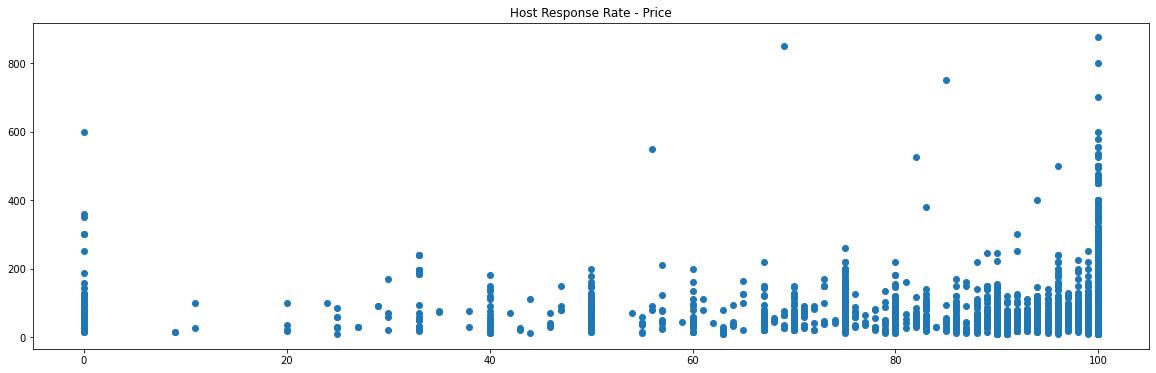

In [75]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train, 'Host Response Rate', 'Price')

# Muestro en pantalla
plt.show()

# Se observa una tendencia ascendente, no se observa outliers claros, aunque si algunos datos dispersos

* **Datos numéricos geográficos**

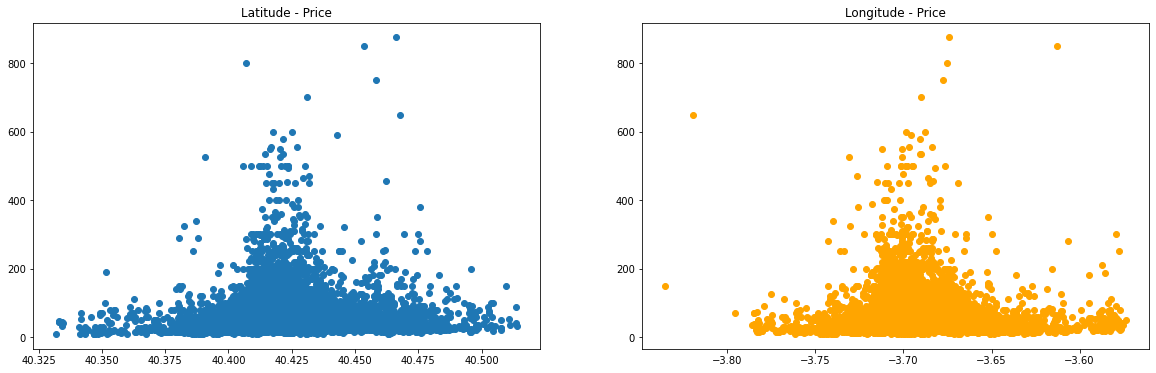

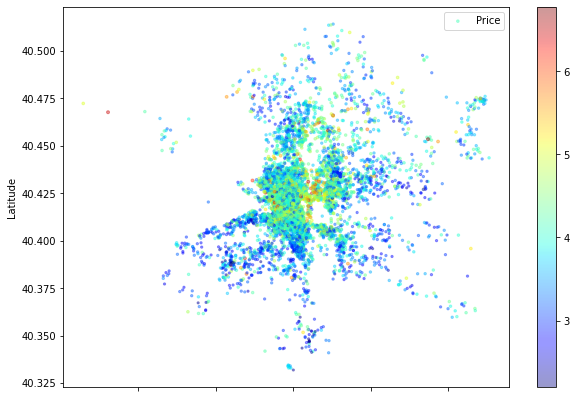

In [76]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 2, 1)
scatter_feature_vs_target_feature(train, 'Latitude', 'Price')
plt.subplot(1, 2, 2)
scatter_feature_vs_target_feature(train, 'Longitude', 'Price', "Orange")

# Muestro en pantalla
plt.show()

# geolocalización
train.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=np.log(train["Price"]*10), label="Price", figsize=(10,7),
    c=np.log(train["Price"]), cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()



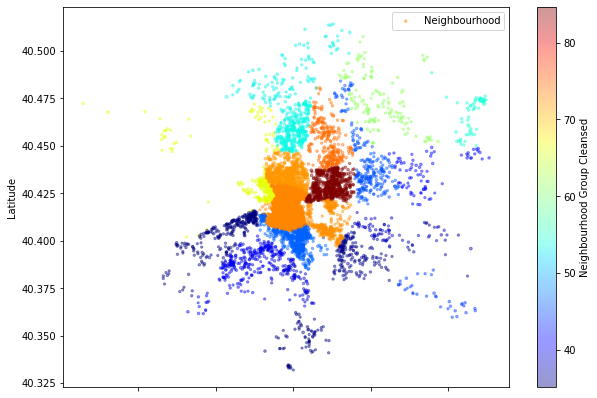

In [77]:
# Se observa una tendencia a precios altos en el centro
train.plot(kind="scatter", x="Longitude", y="Latitude", alpha=0.4,
    s=np.log(train["Price"]*10), label="Neighbourhood", figsize=(10,7),
    c='Neighbourhood Group Cleansed', cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

Se podría clusterizar, pero para ello ya tenemos la característica Neighbourhood Group Cleansed 
que en principio parece que se adapta bien a los precios

* **Datos numéricos dentro de los inmuebles (Bathrooms, Bedrooms, Beds)**

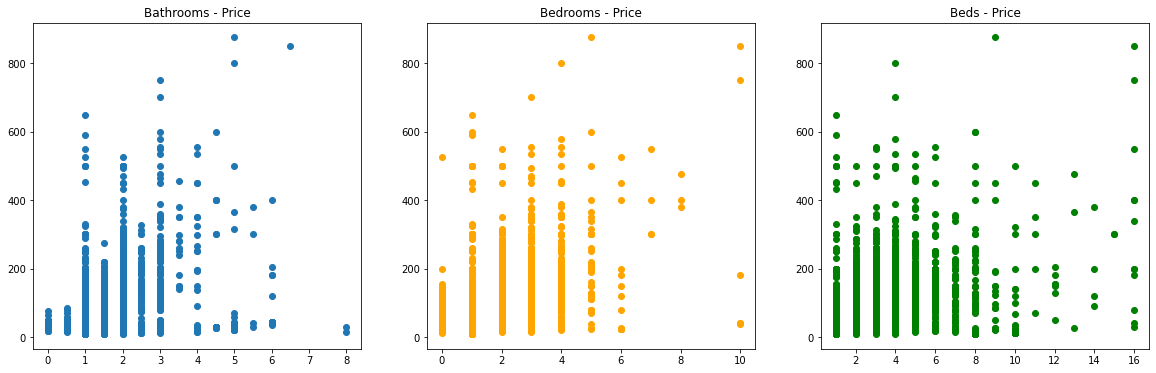

In [78]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 3, 1)
scatter_feature_vs_target_feature(train, 'Bathrooms', 'Price')
plt.subplot(1, 3, 2)
scatter_feature_vs_target_feature(train, 'Bedrooms', 'Price', 'orange')
plt.subplot(1, 3, 3)
scatter_feature_vs_target_feature(train, 'Beds', 'Price', 'green')

# Muestro en pantalla
plt.show()

Observable ligera tendencia ascendente, sin embargo no tanto para Beds (a partir de 4 o 5 camas parece que el precio desciende)

* **Datos numéricos de personas**

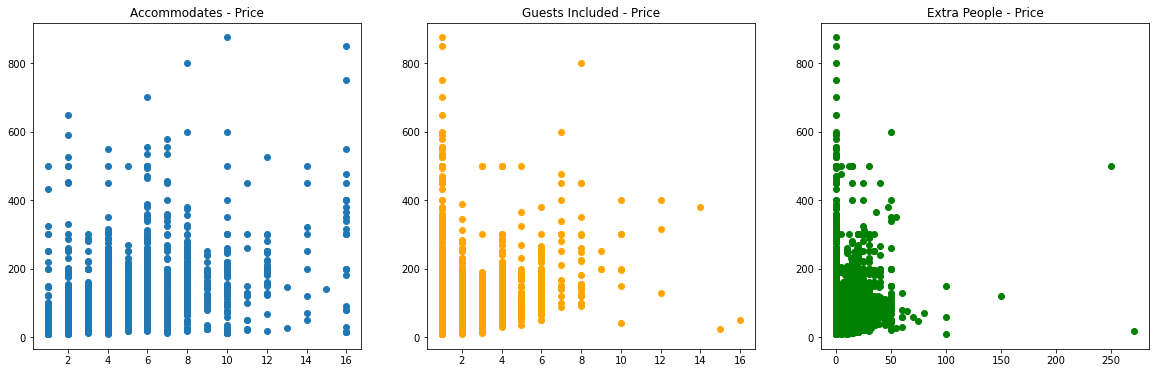

In [79]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 3, 1)
scatter_feature_vs_target_feature(train, 'Accommodates', 'Price')
plt.subplot(1, 3, 2)
scatter_feature_vs_target_feature(train, 'Guests Included', 'Price', 'orange')
plt.subplot(1, 3, 3)
scatter_feature_vs_target_feature(train, 'Extra People', 'Price', 'green')

# Muestro en pantalla
plt.show()

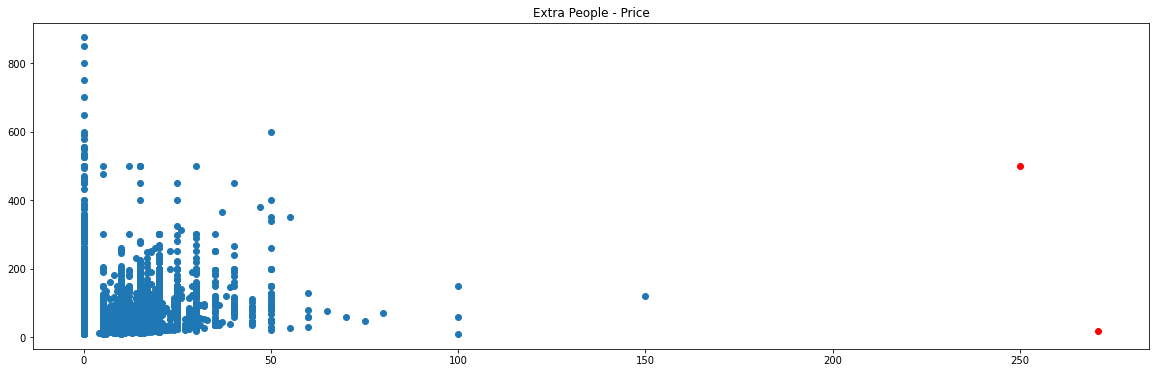

In [80]:
# En este caso, en Extra People, parece que hay muestras extrañas, que podrían considerarse outliers (o bien naves o mansiones)
# podriamos quitarlas sin problemas.

# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train[train['Extra People'] < 200], 'Extra People', 'Price')
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train[train['Extra People'] > 200], 'Extra People', 'Price', color='red')

# Elimino posibles outliers
train.loc[train['Extra People'] > 200] = np.nan

# Muestro en pantalla
plt.show()

In [81]:
# En este caso, en Extra People, parece que hay 3 muestras extrañas, que podrían considerarse outliers (o bien naves o mansiones)
#  podriamos quitarlas sin problemas.
# Nota:
#    Pensé en poner los datos de 0 en NaN, pero no creo que sea realista, 
#    porque creo que los datos pueden ser ciertos y en muchos no permitan gente extra

* **Datos de número de noches**

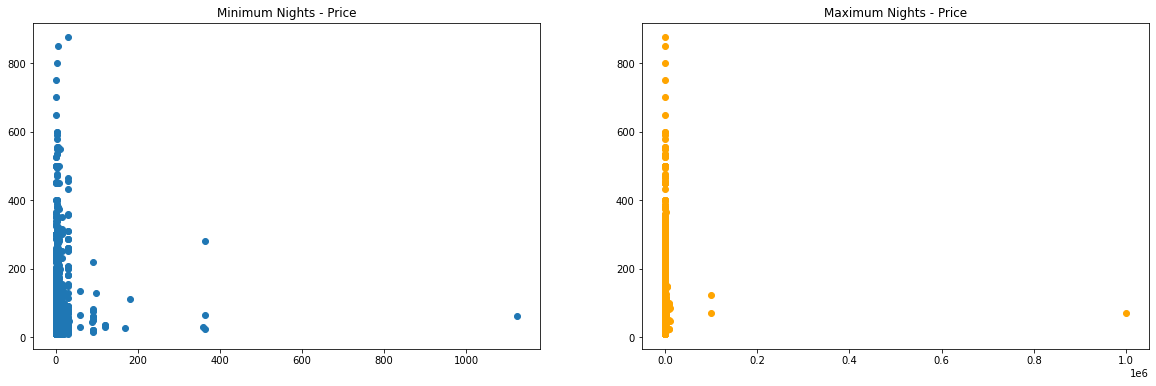

In [82]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 2, 1)
scatter_feature_vs_target_feature(train, 'Minimum Nights', 'Price')
plt.subplot(1, 2, 2)
scatter_feature_vs_target_feature(train, 'Maximum Nights', 'Price', 'orange')

# Muestro en pantalla
plt.show()

In [83]:
# No parece que el número de noches afecte en el precio, además tiene una variabilidad alta y outliers, 
# opto por quitar dichas características
train.drop(['Minimum Nights', 'Maximum Nights'], axis=1, inplace=True)

# Situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 40 columnas


* **Datos númericos de disponibilidad**

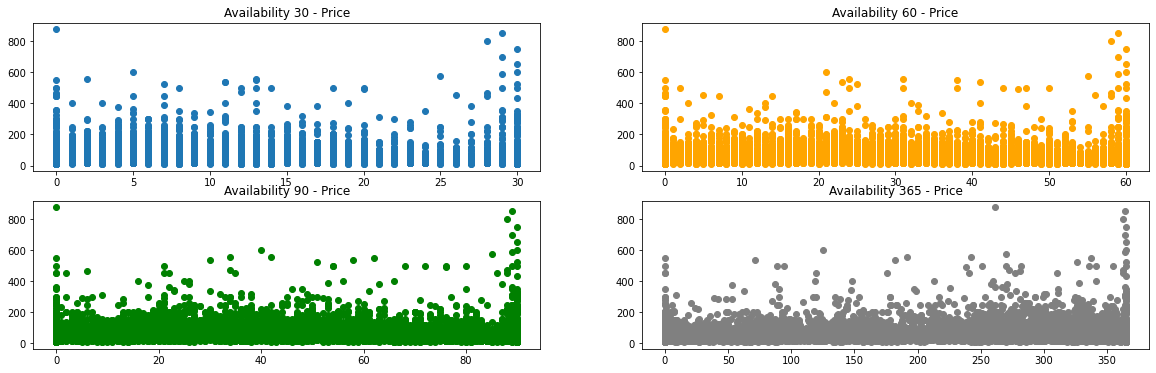

In [84]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(2, 2, 1)
scatter_feature_vs_target_feature(train, 'Availability 30', 'Price')
plt.subplot(2, 2, 2)
scatter_feature_vs_target_feature(train, 'Availability 60', 'Price', 'orange')
plt.subplot(2, 2, 3)
scatter_feature_vs_target_feature(train, 'Availability 90', 'Price', 'green')
plt.subplot(2, 2, 4)
scatter_feature_vs_target_feature(train, 'Availability 365', 'Price', 'gray')

# Muestro en pantalla
plt.show()

In [85]:
# No parece haber outliers, tampoco parece que vaya a ver tendencia, lo analizaremos luego

* **Datos numéricos de Reviews**

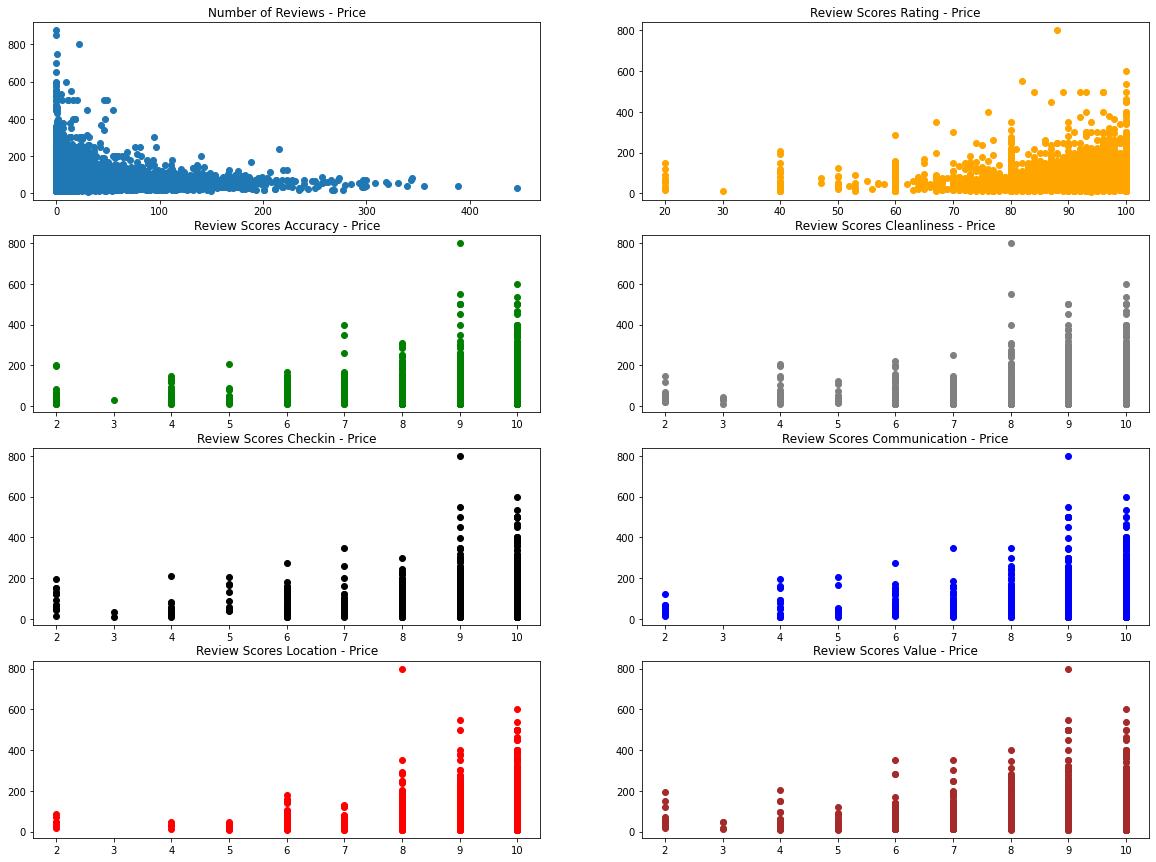

In [86]:
# Tamaño de la figura
plt.figure(figsize=(20,15))

# Subplots
plt.subplot(4, 2, 1)
scatter_feature_vs_target_feature(train, 'Number of Reviews', 'Price')
plt.subplot(4, 2, 2)
scatter_feature_vs_target_feature(train, 'Review Scores Rating', 'Price', 'Orange')
plt.subplot(4, 2, 3)
scatter_feature_vs_target_feature(train, 'Review Scores Accuracy', 'Price', 'Green')
plt.subplot(4, 2, 4)
scatter_feature_vs_target_feature(train, 'Review Scores Cleanliness', 'Price', 'Gray')
plt.subplot(4, 2, 5)
scatter_feature_vs_target_feature(train, 'Review Scores Checkin', 'Price', 'Black')
plt.subplot(4, 2, 6)
scatter_feature_vs_target_feature(train, 'Review Scores Communication', 'Price', 'Blue')
plt.subplot(4, 2, 7)
scatter_feature_vs_target_feature(train, 'Review Scores Location', 'Price', 'Red')
plt.subplot(4, 2, 8)
scatter_feature_vs_target_feature(train, 'Review Scores Value', 'Price', 'Brown')

# Muestro en pantalla
plt.show()

In [87]:
# No parece haber outliers, aunque si parece haber tendencia

# En Review Scores Rating, claramente se mezclan datos redondeados 
# con datos continuos, no sé si sería buena idea redondear todos los datos
# imagino que se perdería información, así que no voy a meterle mano

* **Datos numéricos de medida**

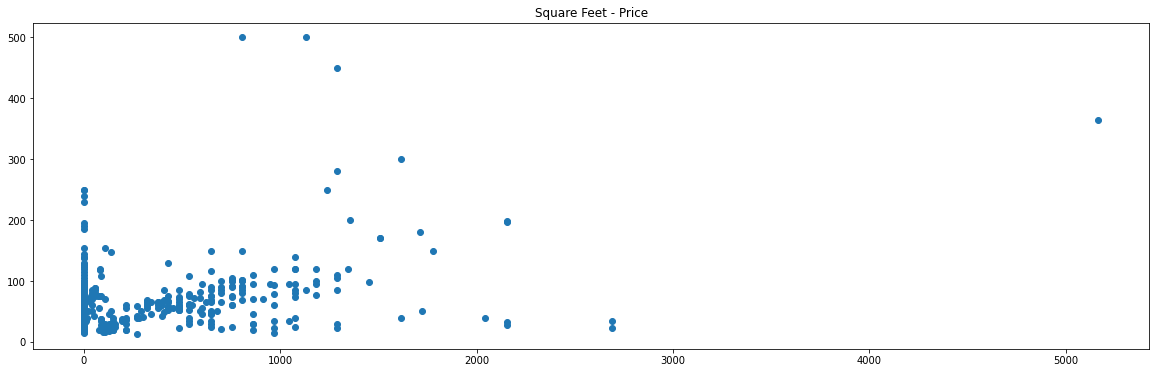

In [88]:
# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train, 'Square Feet', 'Price')

# Muestro en pantalla
plt.show()

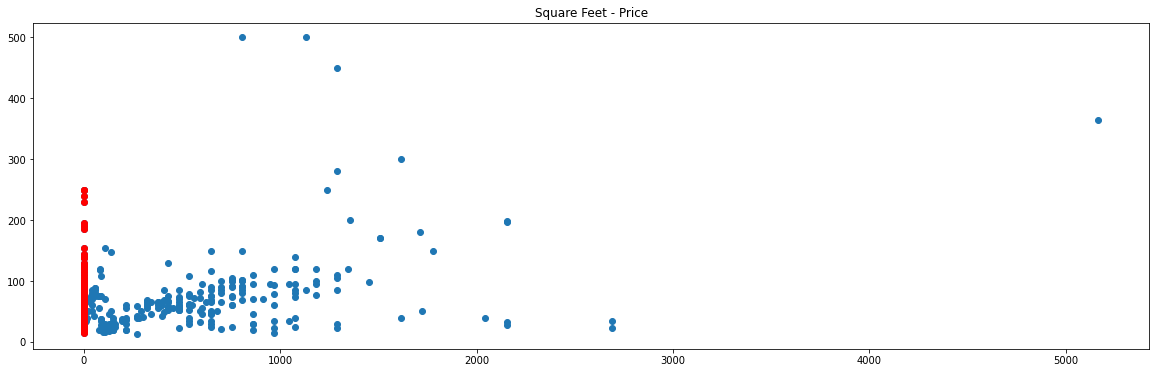

In [89]:
# Podemos encontrar problemas en esta característica, ya que no tiene sentido físico que haya estancias de 0F2
# Se va a considerar como outliers, dado que parece una variable con correlación alta, vamos a estipular los datos faltantes (punto 3)

# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train, 'Square Feet', 'Price')
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train[train['Square Feet'] < 1], 'Square Feet', 'Price', color='red')

# Elimino posibles outliers
train.loc[train['Square Feet'] < 1] = np.nan

# Muestro en pantalla
plt.show()

In [90]:
# La situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 40 columnas


### 2.3.2.- Matriz de correlación


In [91]:
# La correlación nos dice mediante matriz, si existe relación entre pares de características normalizadas entre -1 a 1
train.corr()

,Price,Host Response Rate,Neighbourhood Group Cleansed,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Square Feet,...,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month
Price,1.000000,-0.004476,0.241962,0.068514,-0.018753,0.579157,0.355361,0.529446,0.489794,0.410780,...,0.067575,0.063427,0.091435,-0.004142,0.004333,0.144741,0.026185,0.148610,0.160850,-0.068508
Host Response Rate,-0.004476,1.000000,0.043031,-0.033621,-0.039232,0.056772,-0.038738,0.004917,0.028450,0.095139,...,0.105181,0.087595,0.110627,0.108810,0.105712,0.059500,0.103953,0.048331,-0.060447,0.190699
Neighbourhood Group Cleansed,0.241962,0.043031,1.000000,0.243514,-0.037059,0.144224,0.090846,0.023244,0.071703,0.166574,...,-0.005107,-0.017481,0.007332,-0.009701,-0.015310,0.402523,-0.005088,0.156727,0.134898,0.086918
Latitude,0.068514,-0.033621,0.243514,1.000000,0.261055,-0.004171,0.043046,0.031097,0.015682,0.159153,...,-0.001714,-0.004081,-0.012184,0.008591,0.004654,0.044680,-0.006435,-0.023320,0.010950,-0.067102
Longitude,-0.018753,-0.039232,-0.037059,0.261055,1.000000,-0.053446,0.008590,0.014025,-0.021180,0.004689,...,0.028527,0.025116,0.026355,0.024574,0.015184,-0.099019,0.020948,-0.053332,-0.045757,-0.011693
Accommodates,0.579157,0.056772,0.144224,-0.004171,-0.053446,1.000000,0.342637,0.678711,0.831717,0.478227,...,-0.064787,-0.075218,-0.026671,-0.071040,-0.052992,0.042899,-0.066802,0.204259,0.125751,0.041457
Bathrooms,0.355361,-0.038738,0.090846,0.043046,0.008590,0.342637,1.000000,0.425984,0.387775,0.548585,...,0.004548,0.004589,0.001532,-0.041555,-0.039589,0.048185,0.002293,0.143017,0.179842,-0.063232
Bedrooms,0.529446,0.004917,0.023244,0.031097,0.014025,0.678711,0.425984,1.000000,0.691328,0.539502,...,0.012857,0.000199,0.002767,-0.009026,0.003179,0.003468,-0.000700,0.096630,0.066790,-0.047152
Beds,0.489794,0.028450,0.071703,0.015682,-0.021180,0.831717,0.387775,0.691328,1.000000,0.455350,...,-0.057736,-0.080113,-0.029389,-0.056470,-0.039987,0.001910,-0.057209,0.141324,0.090920,-0.016483
Square Feet,0.410780,0.095139,0.166574,0.159153,0.004689,0.478227,0.548585,0.539502,0.455350,1.000000,...,0.042416,0.055070,0.007132,-0.038118,0.026977,0.026810,0.016048,0.186602,-0.185278,0.008109


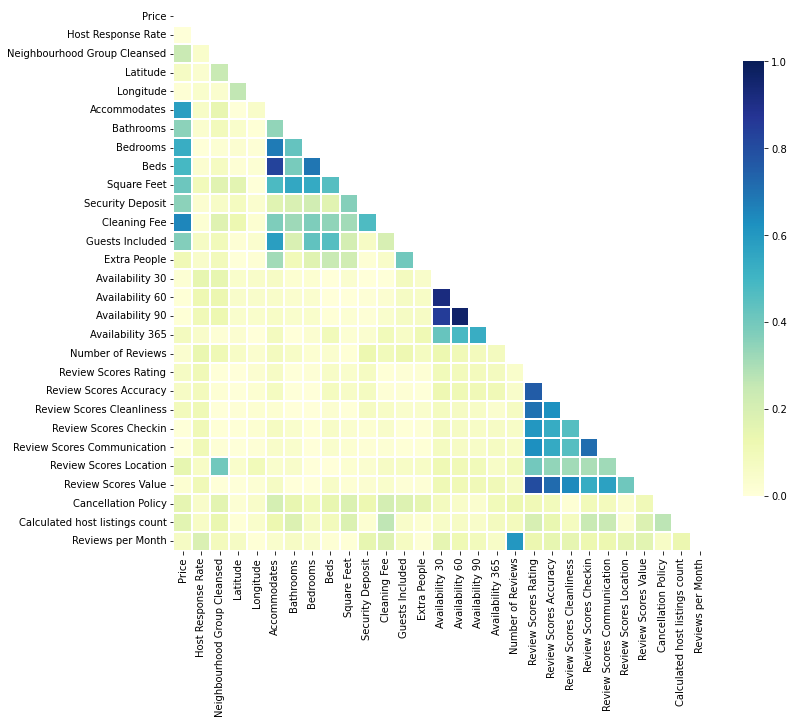

In [92]:
import seaborn as sns

# Compute the correlation matrix
train = train
corr = np.abs(train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

In [93]:
# Visualizar la matriz de correlación, esto tarda así que lo dejo opcional
if visualize_corr_matrix:   
    pd.plotting.scatter_matrix(
        train, 
        alpha=0.2, figsize=(20, 20), diagonal = 'kde')
    plt.show()

## 2.4.- Preprocesamiento

### 2.4.1.- Transformación, buscando distribución normal

Podemos ver en nuestra matriz como el histograma de distintas características no sigue una distribución normal, vamos a realizar transformación a normal, ya que será de ayuda a nuestro modelo

In [94]:
# Función para pasar una distribución Log-Normal a Normal (Log(X+1))
def Lognormal_to_Normal(df, cols=['Price', 'Security Deposit', 'Cleaning Fee']):
    for col in cols:
        df[[col]] = np.log(df[[col]] + 1)
    return df

def Normal_to_Lognormal(df, cols=['Price', 'Security Deposit', 'Cleaning Fee']):
    for col in cols:
        df[[col]] = np.exp(df[[col]]) - 1
    return df

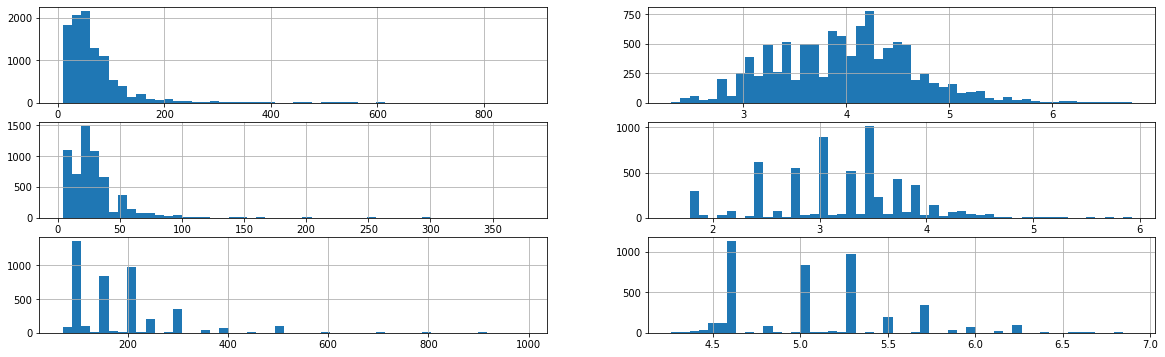

In [95]:
plt.figure(figsize=(20,6))

plt.subplot(3,2,1)
train['Price'].hist(bins=50)
plt.subplot(3,2,3)
train['Cleaning Fee'].hist(bins=50)
plt.subplot(3,2,5)
train['Security Deposit'].hist(bins=50)

train = Lognormal_to_Normal(train)
plt.subplot(3,2,2)
train['Price'].hist(bins=50)
plt.subplot(3,2,4)
train['Cleaning Fee'].hist(bins=50)
plt.subplot(3,2,6)
train['Security Deposit'].hist(bins=50)

plt.show()

### 2.4.2.- Rellenando valores

Hemos comprobado en el apartado anterior que Security Deposit y Cleaning Fee tiene pocos valores, pero tiene importancia su correlación con Price, vamos a realizar un fill Nan para rellenar los valores NaN

In [96]:
print("Antes: {}% de nans".format(100 * train['Security Deposit'].isna().sum() / len(train)))
train['Security Deposit'] = train['Security Deposit'].fillna(df.groupby('Price')['Security Deposit'].transform('mean'))
print("Despues: {}% de nans".format(100 * train['Security Deposit'].isna().sum() / len(train)))

Antes: 58.76318590922288% de nans
Despues: 0.3967869931288106% de nans


In [97]:
print("Antes: {}% de nans".format(100 * train['Cleaning Fee'].isna().sum() / len(train)))
train['Cleaning Fee'] = train['Cleaning Fee'].fillna(df.groupby('Price')['Cleaning Fee'].transform('mean'))
print("Despues: {}% de nans".format(100 * train['Cleaning Fee'].isna().sum() / len(train)))

Antes: 41.952966224716924% de nans
Despues: 0.10645504693699796% de nans


No es necesario pero por valor académico vamos a hacer un modelo de regresión para rellenar los valores nulos de 'Square Feet'

Podriamos ver la Correlación para buscar las características mas significativas
pero por usar otro método vamos a ver mediante f regression y mutual info
simplemente por comparar y ver como funciona (además de cumplir el objetivo)

* **Selección de características (f_regression y mutual_info_regression)**

In [98]:
# Datos
data = train.dropna()
X = data.drop(['Square Feet'], axis=1).select_dtypes(include='number')
y = data['Square Feet']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = seed)
featureNames = X.columns.values

In [99]:
with_nans = 100 * train.isna().sum() / len(train) > 20
with_nans = set(with_nans.index[with_nans])
with_nans

{'Review Scores Accuracy',
 'Review Scores Checkin',
 'Review Scores Cleanliness',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Rating',
 'Review Scores Value',
 'Reviews per Month',
 'Square Feet'}

In [100]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# f-Test
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)

# Mutual Info
mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

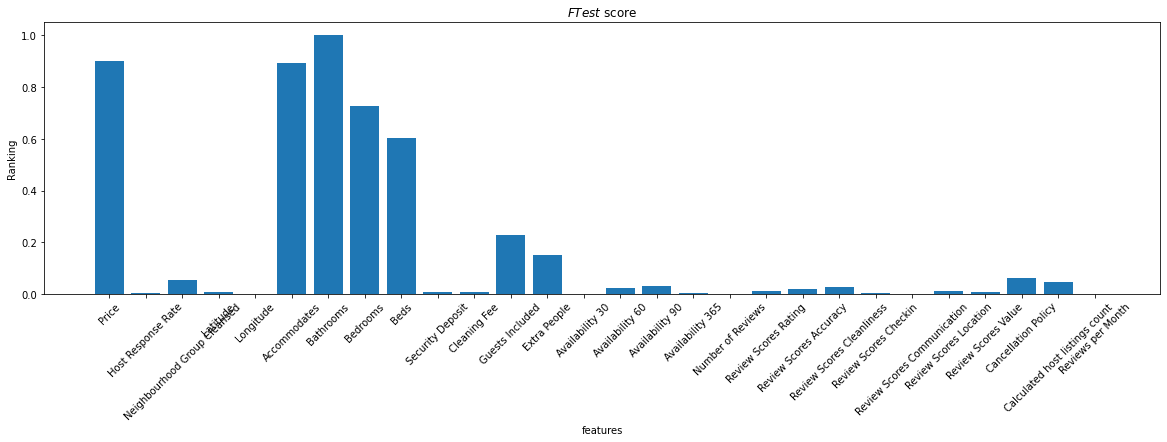

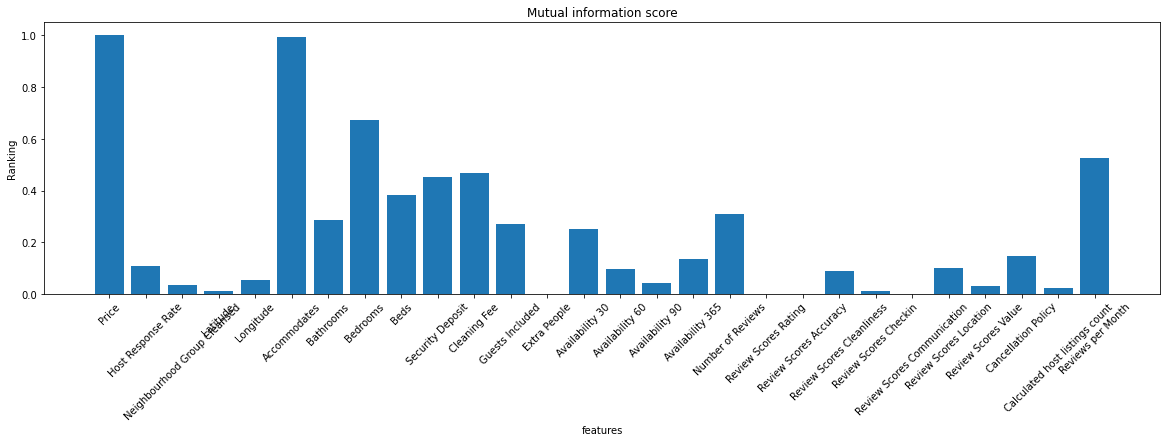

In [101]:
# F-Test
plt.figure(figsize=(20, 5))

plt.bar(range(X.shape[1]), f_test,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

# Mutual Info
plt.figure(figsize=(20, 5))

plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

In [102]:
# Mismo criterio de selección (para los 2 seleccionar los 5 mejores)
from sklearn.feature_selection import SelectKBest

n_cols = 5

# F-Test
sel_five_cols = SelectKBest(f_regression, k=n_cols)
sel_five_cols.fit(X_train, y_train)
f_test_features = featureNames[sel_five_cols.get_support()]

# Mutual-Test
sel_five_cols = SelectKBest(mutual_info_regression, k=n_cols)
sel_five_cols.fit(X_train, y_train)
mi_features = featureNames[sel_five_cols.get_support()]

print("f-test: {}".format(f_test_features))
print("m-test: {}".format(mi_features))

f-test: ['Price' 'Accommodates' 'Bathrooms' 'Bedrooms' 'Beds']
m-test: ['Price' 'Accommodates' 'Bedrooms' 'Cleaning Fee' 'Reviews per Month']


In [103]:
len(train[mi_features[4]].dropna())

8021

In [104]:
# Comprobemos como se comportan, por ejemplo con regresión lineal + regularización elasticnet(w1*lasso + [1-w1]*ridge)
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Modelos
model_f = ElasticNet()
model_m = ElasticNet()

# Define grid
param_grid = dict()
param_grid['alpha'] = np.logspace(-3, 0, 20)
param_grid['l1_ratio'] = np.logspace(-3, 0, 20)
param_grid['random_state'] = [seed]

# define search
grid_f = GridSearchCV(model_f, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)
grid_m = GridSearchCV(model_m, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=-1)

# Fit
grid_f.fit(X_train[f_test_features], y_train)
grid_m.fit(X_train[mi_features], y_train)

# Predict
y_hat_f = grid_f.predict(X_test[f_test_features])
y_hat_m = grid_m.predict(X_test[mi_features])

mse_f = mean_squared_error(y_test, y_hat_f)
mse_m = mean_squared_error(y_test, y_hat_m)

print('F-test: {}'.format(mse_f))
print('Mutual Information: {}'.format(mse_m))

Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Fitting 10 folds for each of 400 candidates, totalling 4000 fits
F-test: 94954.44362752291
Mutual Information: 121061.94464013423


In [105]:
# El mejor modelo
if (mse_f < mse_m):
    mse = mse_f
    grid = grid_f
    features = f_test_features
else:
    mse = mse_m
    grid = grid_m
    features = mi_features

scores = -1*np.array(grid.cv_results_['mean_test_score'])

In [106]:
def fill_NaNs_SquareFeet(df, cols, grid):
    # Predecimos valores de Square Feet con nuestro modelo entrenado en train
    X = df[df['Square Feet'].isna()][cols].dropna()
    print(len(X))
    y_hat = grid.predict(X[cols])
    df.loc[X.index.values,'Square Feet'] = y_hat
    return df

9878


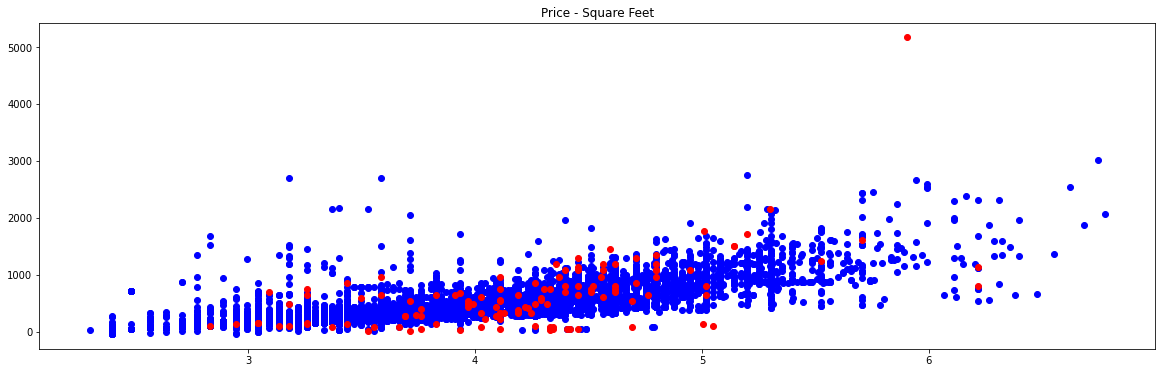

In [107]:
# Pues ahora solo queda rellenar los valores
train = fill_NaNs_SquareFeet(train, features, grid)

# Tamaño de la figura
plt.figure(figsize=(20,6))

# Subplots
plt.subplot(1, 1, 1)
scatter_feature_vs_target_feature(train[~train.index.isin(X.index)], 'Price', 'Square Feet', color='blue')
scatter_feature_vs_target_feature(train[train.index.isin(X.index)], 'Price', 'Square Feet', color='red')

In [108]:
# Podemos comprobar mediante visualización que se comporta de forma viable, pero también predice valores negativos, 
# lo cual es un problema, haremos comparación en el modelo final incluyendo o no esta característica

### 2.4.3.- Combinación de variables, reducción de dimensionalidad y otras transformaciones

* **Pies Cuadrados a Metros Cuadrados**

In [109]:
# Función para pasar de pies2 a metros2
def feet_to_meters(df):
    feet_to_m2 = 0.09290304
    df['Square Meters'] = df['Square Feet'].apply(lambda x: x * feet_to_m2)
    df = df.drop('Square Feet', axis=1)
    return df

In [110]:
# Pies cuadrados a Metros cuadrados (Y hacemos drop de Feet, ya que no nos aportan información nueva)
train = feet_to_meters(train)

* **Barrios / Distritos vs Código Postal**

In [111]:
# Estas 2 variables están bastante correladas como pudimos ver en la matriz de correlación
train[['Price', 'Neighbourhood Group Cleansed', 'Zipcode']].corr()

,Price,Neighbourhood Group Cleansed
Price,1.00000,0.34844
Neighbourhood Group Cleansed,0.34844,1.00000


In [112]:
# Parece que Zipcode está un poco mas correlada con Price, sin embargo esta viene de una característica con muchos más valores únicos
# Por lo que me quedo mejor con Neighbourhood Group Cleansed
print(mean_map['Neighbourhood Group Cleansed'].size)
print(mean_map['Zipcode'].size)

49
60


In [113]:
train.drop('Zipcode', axis=1, inplace=True)

# La situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 39 columnas


* **Availability**

In [114]:
train[['Price', 'Availability 30', 'Availability 60', 'Availability 90']].corr()

,Price,Availability 30,Availability 60,Availability 90
Price,1.000000,-0.044109,-0.044881,-0.054495
Availability 30,-0.044109,1.000000,0.920616,0.850700
Availability 60,-0.044881,0.920616,1.000000,0.964238
Availability 90,-0.054495,0.850700,0.964238,1.000000


In [115]:
# Las disponibilidades están fuertemente correlacionadas entre ellas, sin embargo dado que con respecto a Price
# tiene una correlación tan cercanas a 1, opto por quitarlas 
train.drop(['Availability 30', 'Availability 60', 'Availability 90'], axis=1, inplace=True)

# La situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 36 columnas


* **Reviews**

In [116]:
cols = [col for col in train.columns if 'review' in str.lower(col)]
cols.insert(0, 'Price')
abs(train[cols].corr())

,Price,Number of Reviews,Review Scores Rating,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per Month
Price,1.000000,0.025846,0.078736,0.081029,0.117061,0.020148,0.033833,0.200369,0.035697,0.022341
Number of Reviews,0.025846,1.000000,0.043268,0.049495,0.072110,0.058157,0.059525,0.096845,0.070019,0.602979
Review Scores Rating,0.078736,0.043268,1.000000,0.754660,0.700077,0.604348,0.626133,0.399002,0.800893,0.131922
Review Scores Accuracy,0.081029,0.049495,0.754660,1.000000,0.623953,0.535044,0.540372,0.340802,0.717905,0.144788
Review Scores Cleanliness,0.117061,0.072110,0.700077,0.623953,1.000000,0.459815,0.456353,0.316035,0.642949,0.148449
Review Scores Checkin,0.020148,0.058157,0.604348,0.535044,0.459815,1.000000,0.713223,0.299302,0.534857,0.128849
Review Scores Communication,0.033833,0.059525,0.626133,0.540372,0.456353,0.713223,1.000000,0.317421,0.570699,0.127977
Review Scores Location,0.200369,0.096845,0.399002,0.340802,0.316035,0.299302,0.317421,1.000000,0.406743,0.152390
Review Scores Value,0.035697,0.070019,0.800893,0.717905,0.642949,0.534857,0.570699,0.406743,1.000000,0.161134
Reviews per Month,0.022341,0.602979,0.131922,0.144788,0.148449,0.128849,0.127977,0.152390,0.161134,1.000000


In [117]:
# La mayoría de características reviews, están correladas entre si, pero solo Review Scores Location pasa del 0.1 con respecto a Price
# Así que nos quedamos esta característica y dropeamos las demás
cols.remove('Price')
cols.remove('Review Scores Location')
train.drop(cols, axis=1, inplace=True)

# La situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 28 columnas


* **Eliminación de características con alto número de NaNs**

In [118]:
#Columnas con mas de 20% valores nulos
with_nans = 100 * train.isna().sum() / len(train) > 20
with_nans = set(with_nans.index[with_nans])
with_nans

{'Review Scores Location'}

In [119]:
train.drop(columns=with_nans, axis=1, inplace=True)

# La situación actual
print("Tenemos {} filas y {} columnas".format(train.shape[0], train.shape[1]))

Tenemos 10333 filas y 27 columnas


* **Selección de características final y limpieza de Nans**

In [120]:
# Datos
data = train.dropna()
X = data.drop(['Price'], axis=1).select_dtypes(include='number')
y = data['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = seed)
featureNames = X.columns.values

In [121]:
f_test, _ = f_regression(X_train, y_train)
f_test /= np.max(f_test)

mi = mutual_info_regression(X_train, y_train)
mi /= np.max(mi)

corr = abs(train.dropna().corr())

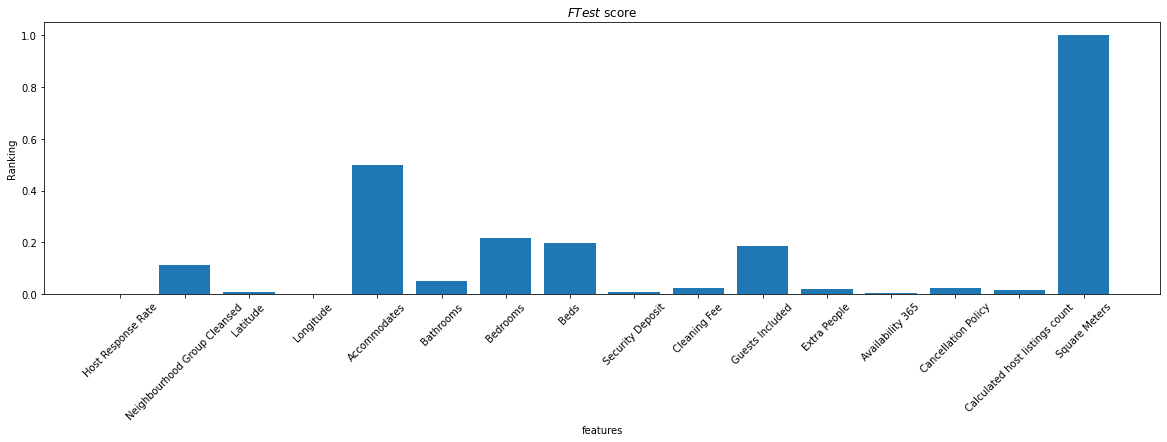

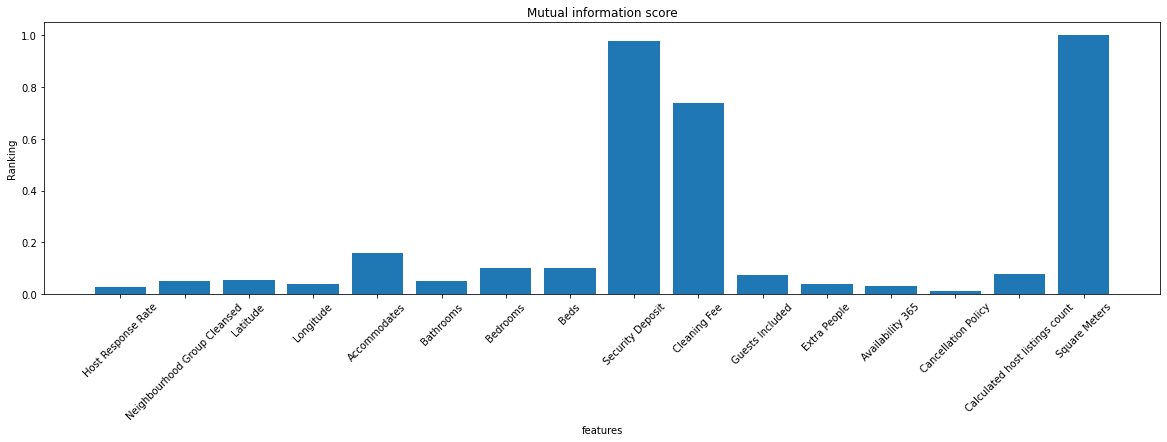

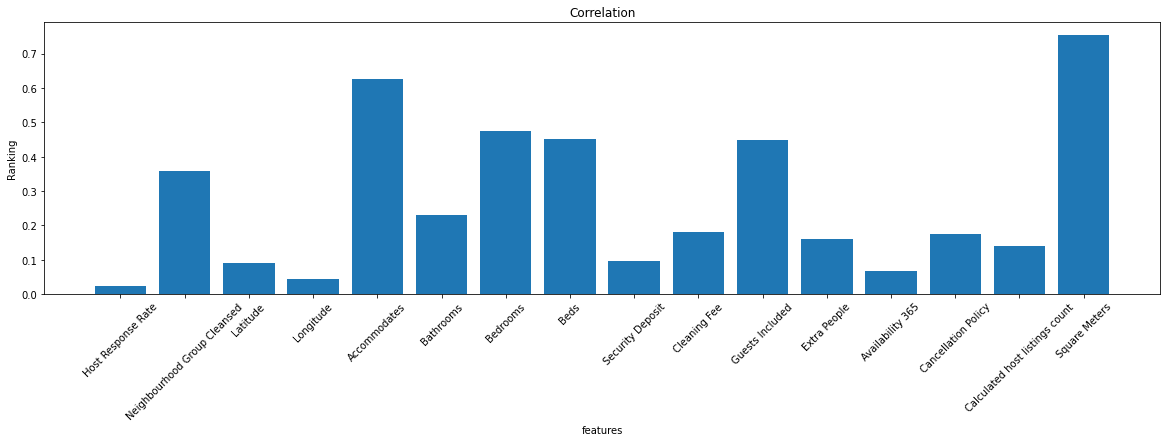

Square Meters                     0.917799
Accommodates                      0.428613
Security Deposit                  0.360314
Cleaning Fee                      0.314679
Bedrooms                          0.264265
Beds                              0.249454
Guests Included                   0.237051
Neighbourhood Group Cleansed      0.173769
Bathrooms                         0.109507
Calculated host listings count    0.078257
Extra People                      0.072766
Cancellation Policy               0.071152
Latitude                          0.051461
Availability 365                  0.033711
Longitude                         0.027940
Host Response Rate                0.016715
Name: Price, dtype: float64


In [122]:
# F-Test
plt.figure(figsize=(20, 5))

plt.bar(range(X.shape[1]), f_test,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F Test$ score')

# Mutual-Test
plt.figure(figsize=(20, 5))

plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

corr['Price']
plt.figure(figsize=(20, 5))

plt.bar(corr['Price'][1:].index, corr['Price'][1:],  align="center")
plt.xticks(range(X.shape[1]), featureNames, rotation = 45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Correlation')

plt.show()

res = (f_test + mi + corr['Price'][1:]) / 3
print(res.sort_values(ascending=False))

In [123]:
# Como criterio voy a seleccionar las características mayor de 0.1 en el ranking
# Y además no perder las columnas de imágenes
cols = corr['Price'][1:][(f_test + mi + corr['Price'][1:]) / 3 > 0.1].index
train = train[cols.insert(0, 'Price').insert(1, 'Image').insert(2, 'Image Loaded')]

In [124]:
# Eliminamos las que no tenga imágenes cargadas
train = train[train['Image Loaded'] == True]
train.drop(columns='Image Loaded', axis=1, inplace=True)

In [125]:
# Eliminamos todos los nan values
train = train.dropna()

In [126]:
train.shape

(8170, 11)

In [127]:
train.describe()

,Price,Neighbourhood Group Cleansed,Accommodates,Bathrooms,Bedrooms,Beds,Security Deposit,Cleaning Fee,Guests Included,Square Meters
count,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000,8170.000000
mean,3.911574,65.542308,3.078825,1.250612,1.279070,1.945410,99.299837,10.754747,1.553366,41.958915
std,0.637002,14.060765,1.976209,0.595164,0.799201,1.512411,83.995461,12.484194,1.081864,27.042258
min,2.397895,35.130435,1.000000,0.000000,0.000000,1.000000,4.262680,1.609438,1.000000,-3.652620
25%,3.433987,53.473262,2.000000,1.000000,1.000000,1.000000,5.303305,3.044522,1.000000,23.857761
50%,3.931826,73.134428,2.000000,1.000000,1.000000,1.000000,138.504587,3.713572,1.000000,35.469640
75%,4.330733,73.134428,4.000000,1.000000,1.000000,2.000000,165.333333,16.024155,2.000000,52.527322
max,6.746412,84.663408,16.000000,8.000000,10.000000,16.000000,860.000000,205.000000,16.000000,279.956591


In [128]:
train.columns

Index(['Price', 'Image', 'Neighbourhood Group Cleansed', 'Accommodates',
       'Bathrooms', 'Bedrooms', 'Beds', 'Security Deposit', 'Cleaning Fee',
       'Guests Included', 'Square Meters'],
      dtype='object')

In [129]:
# Libero memoria
vars_checkpoint = Liberando_memoria(vars_checkpoint, ['train', 'test'])

# 3.- MLP

En este apartado vamos a buscar una buena estructura **MLP (Multi Layer Perceptron)** para nuestros datos (sin imágenes) para ello vamos a hacer un pequeño **Hyperparameter Tuning** para no demorar demasiado y encontrar un modelo aceptable

## 3.1.- Set de validación

El primer paso es obtener un set de validación dividiendo nuestro set de entrenamiento, para acercarse a un modelo que se comporte bien con datos que no ve en el entrenamiento

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train.drop('Price', axis=1).drop('Image', axis=1),
    train[['Price']],
    test_size = 0.20,
    random_state=seed, 
    shuffle=True)
    
print("X_train.shape: {}, X_val.shape: {}".format(X_train.shape, X_val.shape))

X_train.shape: (6536, 9), X_val.shape: (1634, 9)


## 3.2.- Normalizado (Standarizado) de datos de entrada

In [131]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

## 3.3.- Construcción del modelo

### 3.3.1.- Definición de las funciones de perdida

En este caso voy a implementar el coeficiente de determinación $R^2$ ya que keras no lo trae por defecto, también unas funciones de **MSE** y **RMSE** donde las entradas están elevada exponencialmente para volver a la distribución original (solo para las métricas), por último, la función de perdida usada por la red es una combinación de el **coeficiente de determinación** y **MSE** 

$$(R^2 - 1) * w_1 * (-1) + MSE * w_2$$

**Nota:** $(R^2 - 1)$ nos dará un coeficiente de determinación donde $0$ es el mejor de los resultados y multiplicado por $(-1)$ para que todos los posibles rangos sean positivos, así marcaremos el objetivo claro de minimizar la función de perdidas a $0$ para conseguir un $R^2$ cercano a 1

In [132]:
# Coeficiente de determinación R^2 (mediante tensorflow para loss function)
def R2(y, y_pred):
    residual_sum_of_squares = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total_sum_of_squares  = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    R_squared = tf.subtract(1.0, tf.divide(residual_sum_of_squares, total_sum_of_squares))
    return R_squared

# función de perdidas que minimize R^2 y MSE
def my_loss_function(y, y_pred):
    part_R2 = 0.5
    r2_loss = R2(y, y_pred)
    part_MSE = 0.5
    mse_loss = tf.keras.losses.mean_squared_error(y, y_pred)
    return part_R2 * -1 * (r2_loss - 1) + part_MSE * mse_loss

### 3.3.2.- Definición de las métricas (Mediante Callback)

Las metricas se van a definir mediante callbacks ya que es mas flexible que mediante metrics, asi podemos usar métricas definidas en sklearn sin problemas, en concreto se guardar al finalizar cada época

In [133]:
from sklearn.metrics import r2_score, mean_squared_error

class MyMetrics(tf.keras.callbacks.Callback):
    
    def __init__(self, x, y, x_val, y_val):
        self.x = x
        self.y = y
        self.x_val = x_val
        self.y_val = y_val
        self.r2 = []
        self.adj_r2 = []
        self.mse = []
        self.rmse = []
        self.val_r2 = []
        self.val_adj_r2 = []
        self.val_mse = []
        self.val_rmse = []
    
    def on_epoch_end(self, epoch, logs={}):
        gc.collect()
        
        # Accedo a las variables
        x = self.x
        x_val = self.x_val
        y = np.exp(self.y) - 1
        y_val = np.exp(self.y_val) - 1
        
        # Hago predicción
        y_pred = np.exp(self.model.predict(x)) - 1
        y_val_pred = np.exp(self.model.predict(x_val)) - 1
        
        # Calculo R2 (EXP y - EXP y_pred)
        r2 = r2_score(y, y_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        self.r2.append(r2)
        self.val_r2.append(val_r2)
        
        # Cálculo de Adjusted R2 (EXP y - EXP y_pred)
        if len(x.shape) < 3:
            adj_r2 = 1 - (1-r2) * (x.shape[0] -1) / (x.shape[0]-x.shape[1]-1)
            val_adj_r2 = 1 - (1-val_r2) * (x.shape[0] -1) / (x.shape[0]-x.shape[1]-1)
            val_r2 = r2_score(y_val, y_val_pred)
            self.adj_r2.append(r2)
            self.val_adj_r2.append(val_r2)
        
        # Calculo MSE (EXP y - EXP y_pred)
        mse = mean_squared_error(y, y_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        self.mse.append(mse)
        self.val_mse.append(val_mse)
        
        # Calculo RMSE (EXP y - EXP y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        self.rmse.append(rmse)
        self.val_rmse.append(val_rmse)
        
        logs["r2"] = r2
        if len(x.shape) < 3:
            logs["adj_r2"] = adj_r2
        logs["mse"] = mse
        logs["rmse"] = rmse
        logs["val_r2"] = val_r2
        if len(x.shape) < 3:
            logs["val_adj_r2"] = val_adj_r2
        logs["val_mse"] = val_mse
        logs["val_rmse"] = val_rmse
        
        gc.collect()
        return

### 3.3.3.- Definición de la estructura del modelo MLP

El modelo seguirá la siguiente estructura:

$$ Dense(n) > [Dense(n*2) > BatchNormalization > Dropout]_{m-1} > Dense(n) > Dense(1)$$

Donde n es el numero de neuronas y m el número de capas "hidden", además se va a usar la función de activación Leaky ReLU y Optimización Adam

In [134]:
# MLP
def My_MLP(n_hidden_layers=1, n_neurons=64, name='mlp'):
    model = Sequential(name=name)
    model.add(Dense(n_neurons, 
                    input_dim=X_train.shape[1], 
                    kernel_initializer='normal', 
                    activation=LeakyReLU(alpha=0.1)))
    for i in range(n_hidden_layers - 1):
        model.add(Dense(n_neurons*2, activation=LeakyReLU(alpha=0.1)))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))
    model.add(Dense(n_neurons*2, activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss=my_loss_function)
    return model

* Descartamos el uso de GridSearchCV y el uso de Cross Validation para no demorar demasiado, por otra parte vamos a definir 4 modelos para probar y testearlos con el set de validación, para así escoger el modelo con mejor comportamiento, también se va a usar un Early Stopping con una toleracia o "paciencia" bastante alta para ahorrar tiempo

In [135]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

@total_time
def Find_the_best_model():
   
    # Mis modelos
    regressors = [
      My_MLP(n_hidden_layers=2, n_neurons=64, name='mlp_0'),
      My_MLP(n_hidden_layers=2, n_neurons=128, name='mlp_1'),
      My_MLP(n_hidden_layers=3, n_neurons=64, name='mlp_2'),
      My_MLP(n_hidden_layers=3, n_neurons=128, name='mlp_3')
    ]
      
    results = []

    # Para cada modelo
    for i, regressor in enumerate(regressors):
        print("MLP {}".format(i))

        # Entrenamiento (y validación)
        results.append(regressor.fit(X_train, y_train, 
                                    validation_data=[X_val, y_val], 
                                    epochs=500, 
                                    batch_size=256,
                                    verbose=2,
                                    callbacks=[MyMetrics(X_train, y_train, X_val, y_val),
                                              EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)]))

    return results

### 3.3.4.- Entrenamiento de los modelos

In [136]:
if find_best_estimator:
    results = Find_the_best_model()

### 3.3.5.- Resultados, visualización y elección del modelo

In [137]:
# Busco la mejor época (dependiendo de mi loss function) en cada uno
if find_best_estimator:
    best_epoch = [np.argmin(result.history['val_loss']) for result in results]

In [138]:
# Muestro los resultados de cada métrica para las mejores épocas
if find_best_estimator:
    results_df = pd.DataFrame()
    results_df["Model"] = ["MLP {}".format(i) for i in range(len(results))]
    results_df["Loss"] = [results[i].history['val_loss'][best_epoch[i]] for i in range(len(results))]
    results_df["R2"] = [results[i].history['val_r2'][best_epoch[i]] for i in range(len(results))]
    results_df["Adjusted R2"] = [results[i].history['val_adj_r2'][best_epoch[i]] for i in range(len(results))]
    results_df["MSE"] = [results[i].history['val_mse'][best_epoch[i]] for i in range(len(results))]
    results_df["RMSE"] = [results[i].history['val_rmse'][best_epoch[i]] for i in range(len(results))]
    results_df["Epoch"] = best_epoch
    
    # Mostramos el dataframe con los resultados
    print(results_df.set_index('Model').sort_values("Loss"))

In [139]:
# Guardo mi mejor modelo y el historial
models_dir = "./Models"
model_filename = "MLP.h5"
historial_filename = "MLP_history.npy"
model_path = models_dir + "/" + model_filename
historial_path = models_dir + "/" + historial_filename

if find_best_estimator:
    # Creo carpeta si no existe
    if not os.path.isdir(models_dir):
        os.mkdir(models_dir)
    # Guardo
    idx_best_model = results_df[results_df["Loss"] == np.min(results_df["Loss"])].index.values[0]
    best_model = results[idx_best_model].model
    best_model.save(model_path)
    np.save(historial_path, results[idx_best_model].history)

In [140]:
# Cargo el modelo y el historial
mlp_history = np.load(historial_path, allow_pickle='TRUE').item()
mlp_model = tf.keras.models.load_model(model_path, 
                                       custom_objects={'my_loss_function': my_loss_function, 'R2':R2})

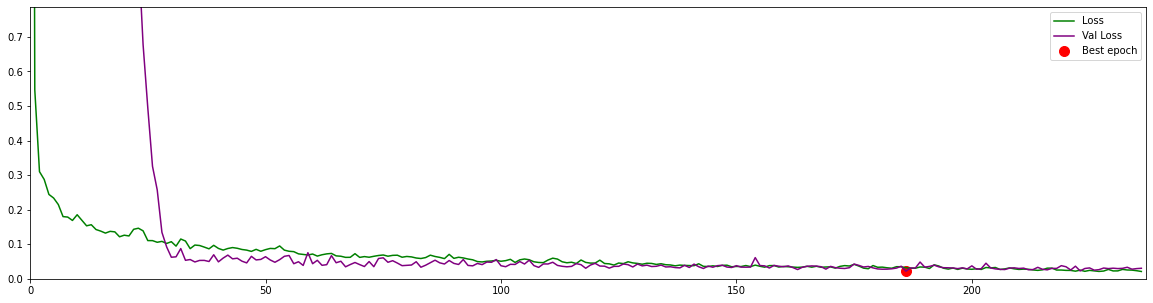

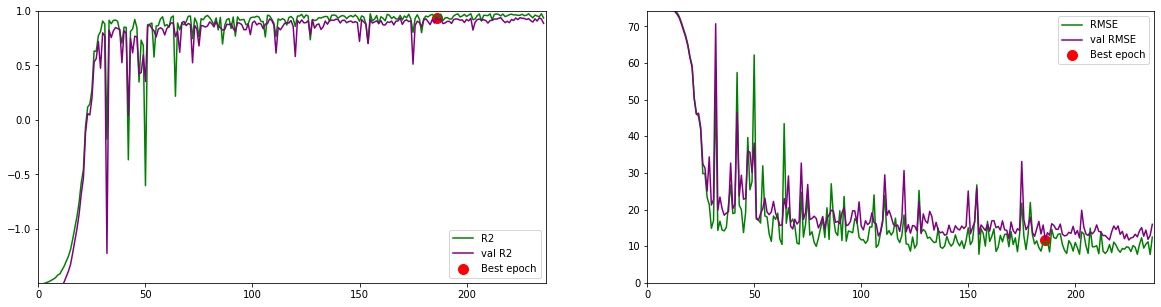

In [141]:
# Vamos a visualizar el mejor modelo
best_epoch = np.argmin(mlp_history['val_loss']) 
plt.figure(figsize=(20, 5))
# Subplot para loss
plt.subplot(1,1,1)
plt.plot(mlp_history["loss"], c = 'Green')
plt.plot(mlp_history["val_loss"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(mlp_history["loss"])
ymin = 0
ymax = np.quantile(mlp_history["val_loss"], 0.9)
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, mlp_history["val_loss"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["Loss", "Val Loss", "Best epoch"])
plt.show()

plt.figure(figsize=(20, 5))

# Subplot para R2
plt.subplot(1,2,1)
plt.plot(mlp_history["r2"], c = 'Green')
plt.plot(mlp_history["val_r2"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(mlp_history["r2"])
ymin = np.quantile(mlp_history["val_r2"], 0.05)
ymax = 1
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, mlp_history["val_r2"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["R2", "val R2", "Best epoch"])

# Subplot para RMSE
plt.subplot(1,2,2)
plt.plot(mlp_history["rmse"], c = 'Green')
plt.plot(mlp_history["val_rmse"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(mlp_history["rmse"])
ymin = 0
ymax = np.quantile(mlp_history["val_rmse"][1:], 0.95)
plt.axis([xmin, xmax, ymin, ymax])
#plt.legend(["RMSE", "val RMSE"])
plt.scatter(best_epoch, mlp_history["val_rmse"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["RMSE", "val RMSE", "Best epoch"])

plt.show()

In [142]:
# Libero memoria
vars_checkpoint = Liberando_memoria(vars_checkpoint)

# 4.- CNN

En este apartado vamos a crear una **CNN (Convolutional Neural Network)**, para ello nos vamos a basar en las imágenes que previamente hemos descargado y tenemos en nuestro dataset, y nuestro objetivo será estimar mediante regressión el mejor modelo para predecir el precio a partir de dichas imágenes

## 4.1.- Preprocesado de imágenes

### 4.1.1.- Parseo de imágenes a tupla numpy

In [143]:
train_tuple = np.array([item[0] for item in train[['Image']].values])

### 4.1.2.- Compresión de imágenes

Vamos a intentar comprimir las imágenes reduciendo su resolución (y memoria), pero intentando que mantenga el aspecto para que afecte lo mínimo a la información.

Para ello, en este caso, voy a usar la **Transformada Discreta del Coseno 2D** para cada canal

In [144]:
# Importamos las librerías para la dct y su inversa de scipy optimizadas
from scipy.fftpack import dct, idct

In [145]:
# Implementamos la transformada 2D y su inversa
def dct2(matrix):
    return dct(dct(matrix.T, norm='ortho').T, norm='ortho')

def idct2(matrix):
    return idct(idct(matrix.T, norm='ortho').T, norm='ortho')

# Implementamos la compresión (mediante crop de la imagen transformada)
def down_res(dct_img, n):
    return dct_img[0:n, 0:n]

# Lo metemos todo en la misma función
def compress(img, n=125):
    # Preparo la salida
    new_img = np.empty((n, n, 3))
    # Separamos los canales
    b,g,r = cv2.split(img)
    # Para canal realizamos los procesos
    b_c = idct2(down_res(dct2(b), n))
    g_c = idct2(down_res(dct2(g), n))
    r_c = idct2(down_res(dct2(r), n))
    # Vuelvo a la misma escala
    def norm(x, xmin, xmax):
        if np.min(x) < xmin:
            x = x + np.abs(np.min(x) - xmin)
        x = (x / np.max(x)) * xmax
        return x
    # Merge de cada canal
    new_img[:,:,0] = norm(b_c, np.min(b), np.max(b))
    new_img[:,:,1] = norm(g_c, np.min(g), np.max(g))
    new_img[:,:,2] = norm(r_c, np.min(r), np.max(r))

    return np.array(new_img, dtype=np.uint8)

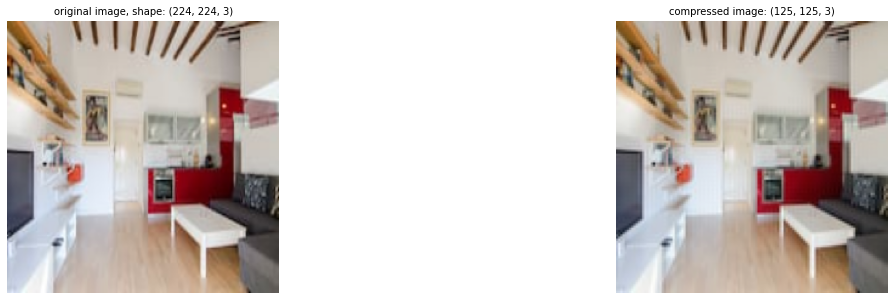

In [146]:
# Comprobación unitaria
plt.figure(figsize=(20, 5))

img = train_tuple[0]
img_c = compress(train_tuple[0], 125)

plt.subplot(1,2,1)
plt.imshow(img), plt.axis('off'), plt.title('original image, shape: {}'.format(img.shape), size=10)
plt.subplot(1,2,2)
plt.imshow(img_c) , plt.axis('off'), plt.title('compressed image: {}'.format(img_c.shape), size=10)
plt.show()

In [147]:
# Aplicamos compresión
if save_formated_images:
    
    import concurrent
    from tqdm import tqdm
    
    new_res = 125
    train_tuple_compressed = np.empty((train_tuple.shape[0], new_res, new_res, 3), dtype=np.uint8)
    
    if sistema == "Windows":
        executor = concurrent.futures.ThreadPoolExecutor()
    else:
        executor = concurrent.futures.ProcessPoolExecutor()
    
    with executor:
        train_tuple_compressed = np.array(
            [img for img in tqdm(executor.map(compress, train_tuple), total=len(train_tuple))],
            dtype=np.uint8)
        
#        for i, img in enumerate(train_tuple):
#            train_tuple_compressed[i, :, :, :] = compress(img, new_res)
    print("Compresión: {}".format(new_res / 244))

### 4.1.3.- Normalizado

En este apartado simplemente vamos a dividir por 255 (es valor máximo de cada canal) y vamos a guardar la variable en float32 (y no 64 que usa por defecto, esto ahorrará recursos)

In [148]:
if save_formated_images:
    train_tuple_compressed = np.divide(train_tuple_compressed, 255, dtype=np.float32) 

In [149]:
# Guardamos por temas de Ram
if save_formated_images:
    np.save('./Images/images_formated.npy', train_tuple_compressed)

In [150]:
# Cargamos
formated_images = np.load('./Images/images_formated.npy')

## 4.2.- Set de validación

Vamos a obtener un set de validación dividiendo nuestro set de entrenamiento, para acercarse a un modelo que se comporte bien con datos que no ve en el entrenamiento

In [151]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    formated_images,
    train[['Price']],
    test_size = 0.20,
    random_state=seed, 
    shuffle=True)
    
print("X_train.shape: {}, X_val.shape: {}".format(X_train.shape, X_val.shape))

X_train.shape: (6536, 125, 125, 3), X_val.shape: (1634, 125, 125, 3)


In [152]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of val examples = " + str(X_val.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(X_val.shape))
print ("Y_test shape: " + str(y_val.shape))
print ("dtype: " + str(X_train.dtype))

number of training examples = 6536
number of val examples = 1634
X_train shape: (6536, 125, 125, 3)
Y_train shape: (6536, 1)
X_test shape: (1634, 125, 125, 3)
Y_test shape: (1634, 1)
dtype: float32


In [153]:
# Libero memoria
vars_checkpoint = Liberando_memoria(['X_train', 'X_val', 'y_train', 'y_val'])

## 4.3.- Construcción del modelo

### 4.3.1.- Estructura CNN

En este apartado vamos a buscar una estructura CNN (Convolutional Neural Network) para nuestros datos (imágenes) para ello vamos a hacer un pequeño Hyperparameter Tuning para no demorar demasiado y encontrar un modelo aceptable.

Definiendo una capa como:
$$ ConvLayer(n) = Conv2D(n) + BatchNormalization + Activation(Relu) + MaxPool2D $$

Entonces:
$$ ConvLayer(n/m+1) > ConvLayer(n - m_i -1)_m > ConvLayer(n*2) > Flatten > FC(32) > FC(1)$$

Con $m = HiddenLayers - 1$ y $stride = 2$ para la última capa

La idea de esta estructura es ir reduciendo las dimensiones de los input a medida que se gana en profuncidad (más filtros) en capas pas profundas, a su vez se intenta tener una salida de Flatten relativamente reducida para reducir el coste computacional en las capas FC (ó Dense)

Usaremos las mismas funciones de perdidas y métricas que en el apartado 3 (MPL)

In [154]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, InputLayer
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [155]:
# CNN
def My_CNN(n_hidden_layers=1, n=32, name='cnn', input_shape=(224, 224, 3), pool_size = (2, 2), kernel_size = (3, 3)):
    
    # Modelo Sequencial
    model = Sequential(name=name)
    
    # Primera capa
    model.add(Conv2D(int(n/(n_hidden_layers+1)), kernel_size = kernel_size, input_shape = input_shape))
    model.add(BatchNormalization(axis=1))
    model.add(tf.keras.layers.Activation(activation='relu'))
    model.add(MaxPool2D(pool_size))
    
    # Capas Hidden
    for i in range(n_hidden_layers - 1):
        model.add(Conv2D(int(n/(n_hidden_layers - i-1)), kernel_size = kernel_size, input_shape = input_shape))
        model.add(BatchNormalization(axis=1))
        model.add(tf.keras.layers.Activation(activation='relu'))
        model.add(MaxPool2D(pool_size))
    
    # Capas finales
    model.add(Conv2D(n*2, kernel_size = kernel_size, input_shape = input_shape, strides=2))
    model.add(BatchNormalization(axis=1))
    model.add(tf.keras.layers.Activation(activation='relu'))
    model.add(MaxPool2D(pool_size))
    model.add(Flatten())
    model.add(Dense(32, activation=LeakyReLU(alpha=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss=my_loss_function)
    return model

In [156]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

@total_time
def Find_the_best_model():
    with tf.device('/cpu:0'):
    
        # Mis modelos
        regressors = [
          My_CNN(n_hidden_layers=2, n=32, name='cnn_0', input_shape=X_train[0].shape),
          My_CNN(n_hidden_layers=3, n=64, name='cnn_1', input_shape=X_train[0].shape),
        ]

        results = []

        # Para cada modelo
        for i, regressor in enumerate(regressors):
            print("CNN {}".format(i))
            gc.collect()

            # Entrenamiento (y validación)
            results.append(regressor.fit(X_train, y_train, 
                                        validation_data=[X_val, y_val], 
                                        epochs=60, 
                                        batch_size=128,
                                        verbose=1,
                                        callbacks=[MyMetrics(X_train, y_train, X_val, y_val),
                                                  EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True)]
                                        ))
        return results

### 4.3.2.- Entrenamiento de los modelos

In [157]:
if find_best_estimator_cnn:
    results = Find_the_best_model()

### 4.3.3.- Resultados, visualización y elección del modelo

In [158]:
# Busco la mejor época (dependiendo de mi loss function) en cada uno
if find_best_estimator_cnn:
    best_epoch = [np.argmin(result.history['val_loss']) for result in results]

In [159]:
# Muestro los resultados de cada métrica para las mejores épocas
if find_best_estimator_cnn:
    results_df = pd.DataFrame()
    results_df["Model"] = ["CNN {}".format(i) for i in range(len(results))]
    results_df["Loss"] = [results[i].history['val_loss'][best_epoch[i]] for i in range(len(results))]
    results_df["R2"] = [results[i].history['val_r2'][best_epoch[i]] for i in range(len(results))]
    results_df["MSE"] = [results[i].history['val_mse'][best_epoch[i]] for i in range(len(results))]
    results_df["RMSE"] = [results[i].history['val_rmse'][best_epoch[i]] for i in range(len(results))]
    results_df["Epoch"] = best_epoch
    
    # Mostramos el dataframe con los resultados
    print(results_df.set_index('Model').sort_values("Loss"))

In [160]:
# Guardo mi mejor modelo y el historial
models_dir = "./Models"
model_filename = "CNN.h5"
historial_filename = "CNN_history.npy"
model_path = models_dir + "/" + model_filename
historial_path = models_dir + "/" + historial_filename

if find_best_estimator_cnn:
    # Creo carpeta si no existe
    if not os.path.isdir(models_dir):
        os.mkdir(models_dir)
    # Guardo
    idx_best_model = results_df[results_df["Loss"] == np.min(results_df["Loss"])].index.values[0]
    best_model = results[idx_best_model].model
    best_model.save(model_path)
    np.save(historial_path, results[idx_best_model].history)

In [161]:
# Cargo el modelo y el historial
cnn_history = np.load(historial_path, allow_pickle='TRUE').item()
cnn_model = tf.keras.models.load_model(model_path, 
                                       custom_objects={'my_loss_function': my_loss_function, 'R2':R2})

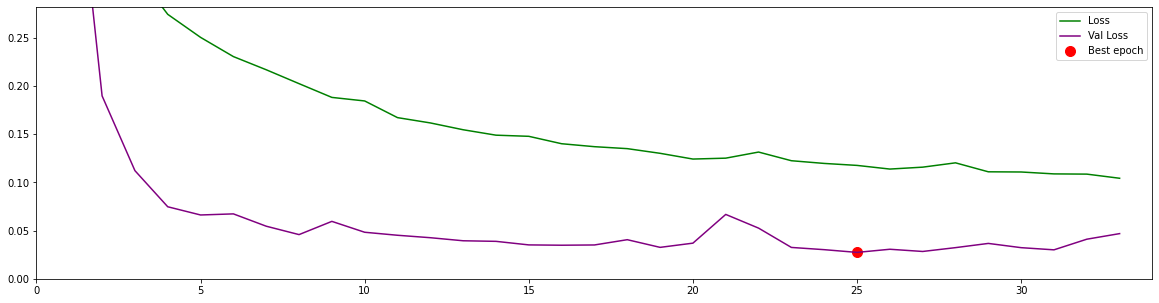

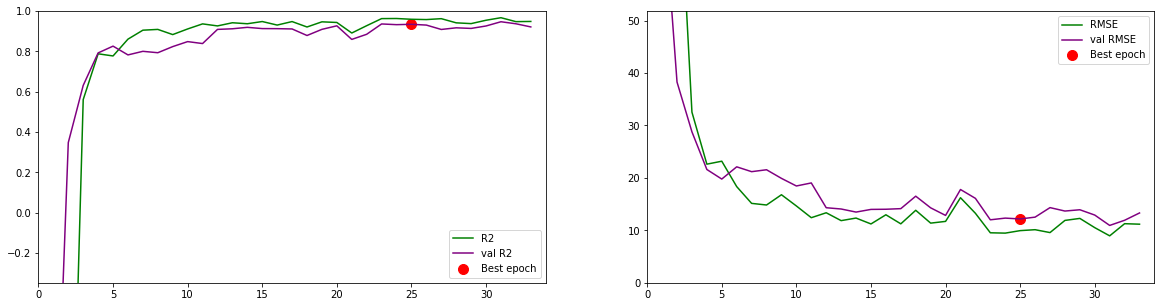

In [162]:
# Vamos a visualizar el mejor modelo
plt.figure(figsize=(20, 5))

best_epoch = np.argmin(cnn_history['val_loss']) 
# Subplot para loss
plt.subplot(1,1,1)
plt.plot(cnn_history["loss"], c = 'Green')
plt.plot(cnn_history["val_loss"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(cnn_history["loss"])
ymin = 0
ymax = np.quantile(cnn_history["val_loss"], 0.95)
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, cnn_history["val_loss"][best_epoch], c = 'red', marker='o', s = 100)
plt.legend(["Loss", "Val Loss", "Best epoch"])
plt.show()

plt.figure(figsize=(20, 5))

# Subplot para R2
plt.subplot(1,2,1)
plt.plot(cnn_history["r2"], c = 'Green')
plt.plot(cnn_history["val_r2"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(cnn_history["r2"])
ymin = np.quantile(cnn_history["val_r2"], 0.05)
ymax = 1
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, cnn_history["val_r2"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["R2", "val R2", "Best epoch"])

# Subplot para RMSE
plt.subplot(1,2,2)
plt.plot(cnn_history["rmse"], c = 'Green')
plt.plot(cnn_history["val_rmse"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(cnn_history["rmse"])
ymin = 0
ymax = np.quantile(cnn_history["val_rmse"], 0.95)
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(["RMSE", "val RMSE"])
plt.scatter(best_epoch, cnn_history["val_rmse"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["RMSE", "val RMSE", "Best epoch"])

plt.show()

In [163]:
# Libero memoria
vars_checkpoint = Liberando_memoria(vars_checkpoint)

# 5.- Modelo final (concatenación de modelos)

## 5.1.- Preparación de los datos

Vamos a usar nuestros datos de train usados tanto en MPL como en CNN, así que vamos a preparar los datos para ordenarlos

### 5.1.1.- Cargamos datos

In [164]:
# MPL
input_1 = train.drop('Image', axis=1).drop('Price', axis=1)
input_1.shape

(8170, 9)

In [165]:
# CNN
input_2 = np.load('./Images/images_formated.npy')
input_2.shape

(8170, 125, 125, 3)

In [166]:
input_id = dict(enumerate(train.index))
input_idx = dict(zip(input_id.values(),input_id.keys()))

## 5.2.- Set de validación

In [167]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    input_1,
    train[['Price']],
    test_size = 0.20,
    random_state=seed, 
    shuffle=True)

In [168]:
train_id = X_train.index # pandas
val_id =  input_1[~input_1.index.isin(X_train.index)].index
train_idx = [input_idx[idd] for idd in train_id] # numpy
val_idx = [input_idx[idd] for idd in val_id] # numpy

In [169]:
X_train_1 = input_1.loc[train_id]
X_train_2 = input_2[train_idx]
X_val_1 = input_1.loc[val_id]
X_val_2 = input_2[val_idx]
y_train = train.loc[train_id][['Price']]
y_val = train.loc[val_id][['Price']]

print("X_train_1.shape: {}, X_val_1.shape: {}".format(X_train_1.shape, X_val_1.shape))
print("X_train_2.shape: {}, X_val_2.shape: {}".format(X_train_2.shape, X_val_2.shape))

X_train_1.shape: (6536, 9), X_val_1.shape: (1634, 9)
X_train_2.shape: (6536, 125, 125, 3), X_val_2.shape: (1634, 125, 125, 3)


### 5.2.1.- Normalización de datos (Solo para el caso del input 1, el input 2 ya se guardó normalizado)

In [170]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_1 = sc.fit_transform(X_train_1)
X_val_1 = sc.transform(X_val_1)

## 5.3.- Construcción del modelo final

### 5.3.1.- Modelo 1 - MLP

In [171]:
model_1 = tf.keras.models.load_model(
    "./Models/MLP.h5", 
    custom_objects={'my_loss_function': my_loss_function, 'R2':R2})

In [172]:
model_1.evaluate(X_val_1, y_val)

52/52 [==============================] - 2s 5ms/step - loss: 0.0236


0.023587016388773918

In [173]:
# Inicio para nombre de las capas del modelo (para ordenar y que no coincidan)
dense_n = 0
batch_normalization_n = 0
dropout_n = 0

print("Model: {} - Input: {}".format(model_1.name, model_1.input.shape))
for i, layer in enumerate(model_1.layers):
    # Rename
    if "dense" in layer.name:
        dense_n = dense_n + 1
        layer._name = "dense_{}".format(dense_n)
    elif "batch_normalization" in layer.name:
        batch_normalization_n = batch_normalization_n + 1
        layer._name = "batch_normalization_{}".format(batch_normalization_n)
    elif "dropout" in layer.name:
        dropout_n = dropout_n + 1
        layer._name = "dropout_{}".format(dropout_n)
    # Trainable
    layer.trainable = True
    # Visualizo
    print("{} - {:30} Trainable: {} \tOutput: {}".format(i, layer.name, layer.trainable, layer.output.shape))

Model: mlp_1 - Input: (None, 9)
0 - dense_1                        Trainable: True 	Output: (None, 128)
1 - dense_2                        Trainable: True 	Output: (None, 256)
2 - batch_normalization_1          Trainable: True 	Output: (None, 256)
3 - dropout_1                      Trainable: True 	Output: (None, 256)
4 - dense_3                        Trainable: True 	Output: (None, 256)
5 - dense_4                        Trainable: True 	Output: (None, 1)


### 5.3.2.- Modelo 2 - CNN

In [174]:
model_2 = tf.keras.models.load_model(
    "./Models/CNN.h5", 
    custom_objects={'my_loss_function': my_loss_function, 'R2':R2})

In [175]:
model_2.evaluate(X_val_2, y_val)

52/52 [==============================] - 5s 13ms/step - loss: 0.6012


0.6011737585067749

In [176]:
# Inicio para nombre de las capas del modelo (para ordenar y que no coincidan)
conv2d_n = 0
activation_n = 0
max_pooling2d_n = 0
flatten_n = 0

print("Model: {} - Input: {}".format(model_2.name, model_2.input.shape))
for i, layer in enumerate(model_2.layers):
    # Rename
    if "conv2d" in layer.name:
        conv2d_n = conv2d_n + 1
        layer._name = "conv2d_{}".format(conv2d_n)
    elif "activation" in layer.name:
        activation_n = activation_n + 1
        layer._name = "activation_{}".format(activation_n)
    elif "max_pooling2d" in layer.name:
        max_pooling2d_n = max_pooling2d_n + 1
        layer._name = "max_pooling2d_{}".format(max_pooling2d_n)
    elif "flatten" in layer.name:
        flatten_n = flatten_n + 1
        layer._name = "flatten_{}".format(flatten_n)
    elif "dense" in layer.name:
        dense_n = dense_n + 1
        layer._name = "dense_{}".format(dense_n)
    elif "batch_normalization" in layer.name:
        batch_normalization_n = batch_normalization_n + 1
        layer._name = "batch_normalization_{}".format(batch_normalization_n)
    elif "dropout" in layer.name:
        dropout = dropout + 1
        layer._name = "dropout_{}".format(dropout)
    
    layer.trainable = True
    print("{} - {:30} Trainable: {} \tOutput: {}".format(i, layer.name, layer.trainable, layer.output.shape))

Model: cnn_1 - Input: (None, 125, 125, 3)
0 - conv2d_1                       Trainable: True 	Output: (None, 123, 123, 16)
1 - batch_normalization_2          Trainable: True 	Output: (None, 123, 123, 16)
2 - activation_1                   Trainable: True 	Output: (None, 123, 123, 16)
3 - max_pooling2d_1                Trainable: True 	Output: (None, 61, 61, 16)
4 - conv2d_2                       Trainable: True 	Output: (None, 59, 59, 32)
5 - batch_normalization_3          Trainable: True 	Output: (None, 59, 59, 32)
6 - activation_2                   Trainable: True 	Output: (None, 59, 59, 32)
7 - max_pooling2d_2                Trainable: True 	Output: (None, 29, 29, 32)
8 - conv2d_3                       Trainable: True 	Output: (None, 27, 27, 64)
9 - batch_normalization_4          Trainable: True 	Output: (None, 27, 27, 64)
10 - activation_3                   Trainable: True 	Output: (None, 27, 27, 64)
11 - max_pooling2d_3                Trainable: True 	Output: (None, 13, 13, 64)
12

### 5.3.3.- Modelo Final - MLP + CNN

In [177]:
# Combinamos 
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model

model_concatenated = concatenate([model_1.layers[4].output, model_2.layers[17].output], axis=1)

model_concatenated = Dense(64, activation=LeakyReLU(alpha=0.1), name="dense_{}".format(dense_n+1)) (model_concatenated)
model_concatenated = Dropout(0.1, name="dropout_{}".format(dropout_n+2)) (model_concatenated)
model_concatenated = Dense(1, name="dense_{}".format(dense_n+4)) (model_concatenated)

model = Model(inputs=[model_1.input, model_2.input], outputs=model_concatenated)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=my_loss_function)

In [178]:
for i, layer in enumerate(model.layers):
    print("{} - {:30} Trainable: {} \tOutput: {}".format(i, layer.name, layer.trainable, layer.output.shape))

0 - conv2d_3_input                 Trainable: True 	Output: (None, 125, 125, 3)
1 - conv2d_1                       Trainable: True 	Output: (None, 123, 123, 16)
2 - batch_normalization_2          Trainable: True 	Output: (None, 123, 123, 16)
3 - activation_1                   Trainable: True 	Output: (None, 123, 123, 16)
4 - max_pooling2d_1                Trainable: True 	Output: (None, 61, 61, 16)
5 - conv2d_2                       Trainable: True 	Output: (None, 59, 59, 32)
6 - batch_normalization_3          Trainable: True 	Output: (None, 59, 59, 32)
7 - activation_2                   Trainable: True 	Output: (None, 59, 59, 32)
8 - max_pooling2d_2                Trainable: True 	Output: (None, 29, 29, 32)
9 - conv2d_3                       Trainable: True 	Output: (None, 27, 27, 64)
10 - batch_normalization_4          Trainable: True 	Output: (None, 27, 27, 64)
11 - activation_3                   Trainable: True 	Output: (None, 27, 27, 64)
12 - max_pooling2d_3                Trainab

In [179]:
from sklearn.metrics import r2_score, mean_squared_error

class MyMetrics(tf.keras.callbacks.Callback):
    
    def __init__(self, x, y, x_val, y_val):
        self.x = x
        self.y = y
        self.x_val = x_val
        self.y_val = y_val
        self.r2 = []
        self.adj_r2 = []
        self.mse = []
        self.rmse = []
        self.val_r2 = []
        self.val_adj_r2 = []
        self.val_mse = []
        self.val_rmse = []
    
    def on_epoch_end(self, epoch, logs={}):
        gc.collect()
        
        # Accedo a las variables
        x = self.x
        x_val = self.x_val
        y = np.exp(self.y) - 1
        y_val = np.exp(self.y_val) - 1
        
        # Hago predicción
        y_pred = np.exp(self.model.predict(x)) - 1
        y_val_pred = np.exp(self.model.predict(x_val)) - 1
        
        # Calculo R2 (EXP y - EXP y_pred)
        r2 = r2_score(y, y_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        self.r2.append(r2)
        self.val_r2.append(val_r2)
        
        # Calculo MSE (EXP y - EXP y_pred)
        mse = mean_squared_error(y, y_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)
        self.mse.append(mse)
        self.val_mse.append(val_mse)
        
        # Calculo RMSE (EXP y - EXP y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        self.rmse.append(rmse)
        self.val_rmse.append(val_rmse)
        
        logs["r2"] = r2
        logs["mse"] = mse
        logs["rmse"] = rmse
        logs["val_r2"] = val_r2
        logs["val_mse"] = val_mse
        logs["val_rmse"] = val_rmse
        
        gc.collect()
        return

In [180]:
if find_best_estimator_mix == True:
    with tf.device('/cpu:0'):
        results = model.fit(
            x=[X_train_1, X_train_2], y=y_train,
            validation_data=([X_val_1, X_val_2], y_val), 
            epochs=40, 
            batch_size=256,
            verbose=2,
            callbacks=[
                MyMetrics([X_train_1, X_train_2], y_train, [X_val_1, X_val_2], y_val),
                       EarlyStopping(monitor='val_loss', mode='min', patience=8, restore_best_weights=True)])

## 5.4.- Resultados

In [181]:
if find_best_estimator_mix == True:
    results.model.save_weights(filepath='./Models/MLP_CNN_weights.h5')
    np.save(historial_path, results.history)

In [182]:
# Cargo los pesos y el historial
model.load_weights('./Models/MLP_CNN_weights.h5')
model_history = np.load("./Models/MLP_CNN_history.npy", allow_pickle='TRUE').item()

In [183]:
# Muestro los resultados de cada métrica para las mejores épocas
best_epoch = np.argmin(model_history['val_loss'])

if find_best_estimator_mix:
    print(pd.DataFrame([model_history[i][best_epoch] for i in model_history.keys()], model_history.keys()))

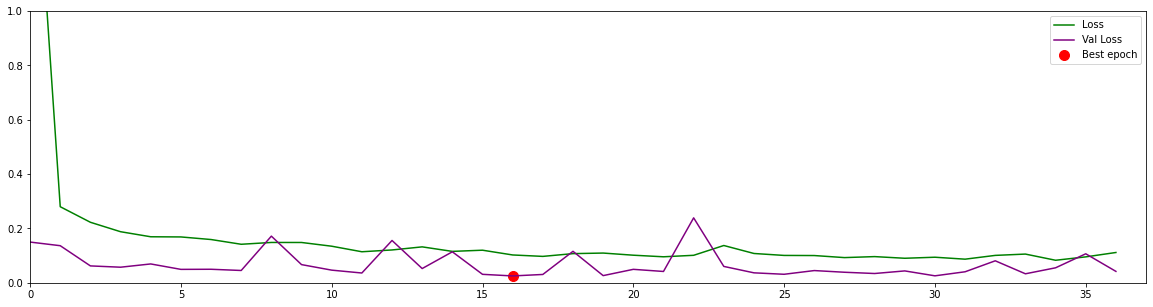

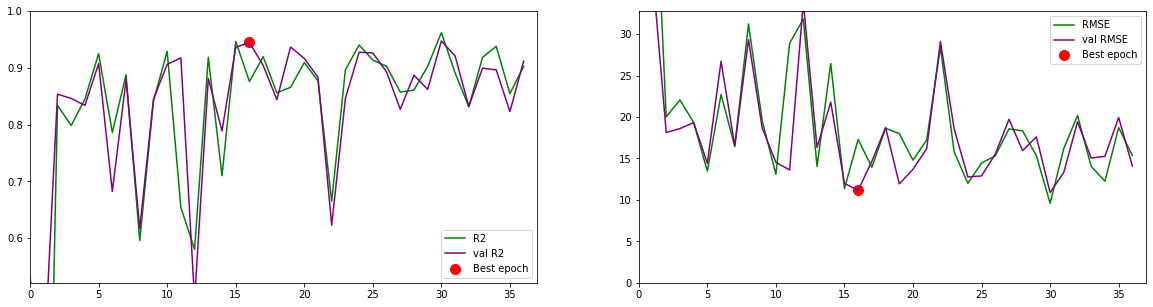

In [184]:
# Vamos a visualizar el mejor modelo
plt.figure(figsize=(20, 5))

best_epoch = np.argmin(model_history['val_loss']) 
# Subplot para loss
plt.subplot(1,1,1)
plt.plot(model_history["loss"], c = 'Green')
plt.plot(model_history["val_loss"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(model_history["loss"])
ymin = 0
ymax = 1
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, model_history["val_loss"][best_epoch], c = 'red', marker='o', s = 100)
plt.legend(["Loss", "Val Loss", "Best epoch"])
plt.show()

plt.figure(figsize=(20, 5))

# Subplot para R2
plt.subplot(1,2,1)
plt.plot(model_history["r2"], c = 'Green')
plt.plot(model_history["val_r2"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(model_history["r2"])
ymin = np.quantile(model_history["val_r2"], 0.05)
ymax = 1
plt.axis([xmin, xmax, ymin, ymax])
plt.scatter(best_epoch, model_history["val_r2"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["R2", "val R2", "Best epoch"])

# Subplot para RMSE
plt.subplot(1,2,2)
plt.plot(model_history["rmse"], c = 'Green')
plt.plot(model_history["val_rmse"], c = 'Purple')
# Ejes
xmin = 0
xmax = len(model_history["rmse"])
ymin = 0
ymax = np.quantile(model_history["val_rmse"], 0.95)
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(["RMSE", "val RMSE"])
plt.scatter(best_epoch, model_history["val_rmse"][best_epoch], c = 'red', marker='o', s =100)
plt.legend(["RMSE", "val RMSE", "Best epoch"])

plt.show()

# 6.- Evaluación y conclusión final

## 6.1.- Preparación datos de train - test

### 6.1.1.- Datos de Train

In [185]:
from sklearn.preprocessing import StandardScaler

# MPL
X_train_1 = train.drop('Image', axis=1).drop('Price', axis=1)
# Normalizamos
sc = StandardScaler()
X_train_1 = sc.fit_transform(X_train_1)

# CNN
X_train_2 = np.load('./Images/images_formated.npy')

In [186]:
y_train = train[['Price']]

### 6.1.2.- Datos de Test

In [187]:
test.shape

(2956, 90)

In [188]:
# Pasamos las columnas a categorical
for c in categorical:
    test[c] = test[c].map(mean_map[c])

In [189]:
test = Lognormal_to_Normal(test)

In [190]:
# Rellenamos valores Nans
test['Security Deposit'] = test['Security Deposit'].fillna(df.groupby('Price')['Security Deposit'].transform('mean'))
test['Cleaning Fee'] = test['Cleaning Fee'].fillna(df.groupby('Price')['Cleaning Fee'].transform('mean'))
test = fill_NaNs_SquareFeet(test, features, grid)

2808


In [191]:
# Pasamos valores de test a m^2
test = feet_to_meters(test)

In [192]:
# Eliminamos las que no tenga imágenes cargadas
test = test[test['Image Loaded'] == True]
test.drop(columns='Image Loaded', axis=1, inplace=True)

In [193]:
# test con las mismas columnas que train
test = test[train.columns]
# Eliminamos todos los nan values
test = test.dropna()
print(test.shape)

(2134, 11)


In [194]:
X_test_1 = sc.transform(test.drop('Image', axis=1).drop('Price', axis=1))
y_test = test[['Price']]

In [195]:
# CNN
test_tuple = np.array([item[0] for item in test[['Image']].values])

# Aplicamos compresión
import concurrent
from tqdm import tqdm
    
new_res = 125
test_tuple_compressed = np.empty((test_tuple.shape[0], new_res, new_res, 3), dtype=np.uint8)

if sistema == "Windows":
    executor = concurrent.futures.ThreadPoolExecutor()
else:
    executor = concurrent.futures.ProcessPoolExecutor()

with executor:
    test_tuple_compressed = np.array(
        [img for img in tqdm(executor.map(compress, test_tuple), total=len(test_tuple))],
        dtype=np.uint8)
        
    print("Compresión: {}".format(new_res / 244))
    
X_test_2 = np.divide(test_tuple_compressed, 255, dtype=np.float32)

100%|█████████████████████████████████████████████████████████████████████████████| 2134/2134 [00:04<00:00, 428.26it/s]


Compresión: 0.5122950819672131


## 6.2.- Evaluación en datos de Test

### 6.2.1.- Evaluación de los 3 modelos (Custom Loss)

In [196]:
with tf.device('/cpu:0'):
    loss_1 = model_1.evaluate(X_train_1, y_train)
    loss_2 = model_2.evaluate(X_train_2, y_train)
    loss = model.evaluate([X_train_1, X_train_2], y_train)

256/256 [==============================] - 36s 140ms/step - loss: 0.0165


In [197]:
with tf.device('/cpu:0'):
    val_loss_1 = model_1.evaluate(X_test_1, y_test)
    val_loss_2 = model_2.evaluate(X_test_2, y_test)
    val_loss = model.evaluate([X_test_1, X_test_2], y_test)

67/67 [==============================] - 12s 174ms/step - loss: 0.0372


### 6.2.2.- Evaluación de los 3 modelos ($R^2$, MSE, RMSE)

In [198]:
with tf.device('/cpu:0'):
    y_pred_1 = model_1.predict(X_train_1)
    y_pred_2 = model_2.predict(X_train_2)
    y_pred = model.predict([X_train_1, X_train_2])

In [199]:
with tf.device('/cpu:0'):
    val_y_pred_1 = model_1.predict(X_test_1)
    val_y_pred_2 = model_2.predict(X_test_2)
    val_y_pred = model.predict([X_test_1, X_test_2])

#### MSE

In [200]:
mse_1 = mean_squared_error(np.exp(y_train) - 1, np.exp(y_pred_1) - 1)
mse_2 = mean_squared_error(np.exp(y_train) - 1, np.exp(y_pred_2) - 1)
mse = mean_squared_error(np.exp(y_train) - 1, np.exp(y_pred) - 1)

In [201]:
val_mse_1 = mean_squared_error(np.exp(y_test) - 1, np.exp(val_y_pred_1) - 1)
val_mse_2 = mean_squared_error(np.exp(y_test) - 1, np.exp(val_y_pred_2) - 1)
val_mse = mean_squared_error(np.exp(y_test) - 1, np.exp(val_y_pred) - 1)

#### RMSE

In [202]:
rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)
rmse = np.sqrt(mse)

In [203]:
val_rmse_1 = np.sqrt(val_mse_1)
val_rmse_2 = np.sqrt(val_mse_2)
val_rmse = np.sqrt(val_mse)

#### $R^2$

In [204]:
r2_1 = r2_score(np.exp(y_train) - 1, np.exp(y_pred_1) - 1)
r2_2 = r2_score(np.exp(y_train) - 1, np.exp(y_pred_2) - 1)
r2 = r2_score(np.exp(y_train) - 1, np.exp(y_pred) - 1)

In [205]:
val_r2_1 = r2_score(np.exp(y_test) - 1, np.exp(val_y_pred_1) - 1)
val_r2_2 = r2_score(np.exp(y_test) - 1, np.exp(val_y_pred_2) - 1)
val_r2 = r2_score(np.exp(y_test) - 1, np.exp(val_y_pred) - 1)

### 6.2.3.- Visualización de resultados

In [206]:
col_names = ["Model", "Loss", "R2", "MSE", "RMSE", "Test_Loss", "Test_R2", "Test_MSE", "Test_RMSE"]
MLP = ["MLP", loss_1, r2_1, mse_1, rmse_1, val_loss_1, val_r2_1, val_mse_1, val_rmse_1]
CNN = ["CNN", loss_2, r2_2, mse_2, rmse_2, val_loss_2, val_r2_2, val_mse_2, val_rmse_2]
MPL_CNN = ["MPL + CNN", loss, r2, mse, rmse, val_loss, val_r2, val_mse, val_rmse]

In [207]:
result = pd.DataFrame([MPL_CNN, MLP, CNN], columns=col_names).set_index("Model")
result

,Loss,R2,MSE,RMSE,Test_Loss,Test_R2,Test_MSE,Test_RMSE
Model,,,,,,,,
MPL + CNN,0.016546,0.953258,111.190397,10.544686,0.037179,0.774180,506.769966,22.511552
MLP,0.517948,0.212898,1872.373014,43.270926,0.540589,-0.203545,2700.907980,51.970261
CNN,12.275426,-1.403332,5717.094800,75.611473,12.125231,-1.438883,5473.163631,73.980833


## 6.3.- Conclusión

En esta práctica hemos podido analizar diferentes modelos de Deep Learning para diferentes tipos de entrada y ser capaz de unirlas, **la estructura final** tiene la siguiente forma:

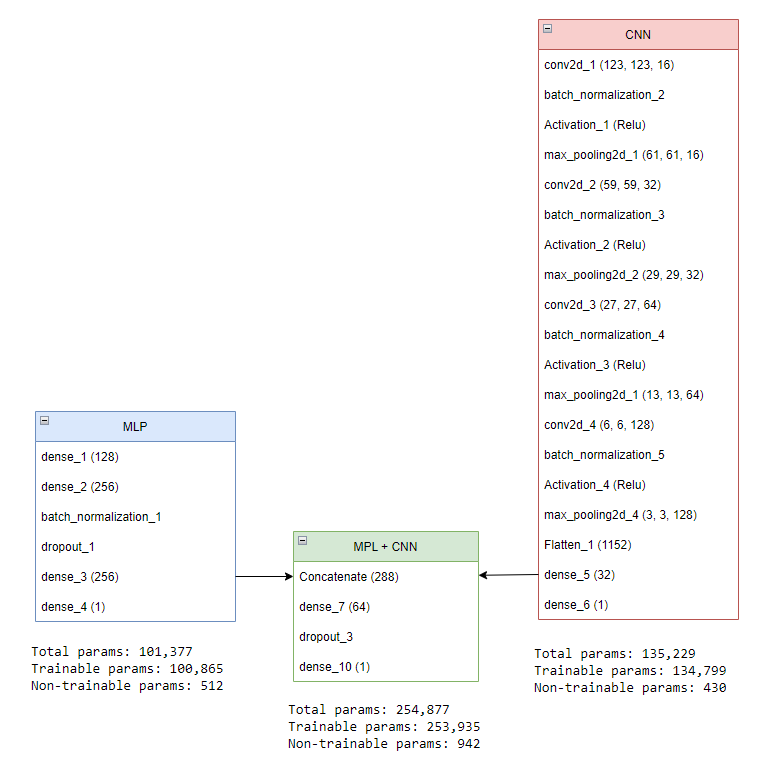

Se ha utilizado la CPU debido limitaciones técnicas (En concreto problemas de VRAM en local y de limitaciones del uso gratuito en Colab), una posible solución hubiera sido utilizar otros recursos de la nube, como AWS ó Google Cloud Platform, con el uso de máquinas en trabajo paralelo dentro de clusters, anque para este proyecto no llegó a ser necesario.

En cuanto a **los resultados**, podemos observar que, el modelo MLP erá bastante bueno para predecir los precios, y aunque CNN por si sola era bastante peor, resulta que la combinación de ambos trabaja realmente bien, con un error **RMSE** de apenas 22.5, con un **Coeficiente de Determinación $R^2$** cercano a 1 (0.77), lo que nos determina la calidad del modelo para predecir datos no vistos, esto es debido a que mide la variación de los resultados.

In [208]:
result

,Loss,R2,MSE,RMSE,Test_Loss,Test_R2,Test_MSE,Test_RMSE
Model,,,,,,,,
MPL + CNN,0.016546,0.953258,111.190397,10.544686,0.037179,0.774180,506.769966,22.511552
MLP,0.517948,0.212898,1872.373014,43.270926,0.540589,-0.203545,2700.907980,51.970261
CNN,12.275426,-1.403332,5717.094800,75.611473,12.125231,-1.438883,5473.163631,73.980833


Por razones que desconozco, Keras no implementa por defecto el coeficiente de determinación $R^2$ a diferencia que SKLearn, así que se ha implementado en este proyecto, y se ha introducido para minimizar la función de pérdidas teniendo en cuenta esto, y el MSE (de los valores de precio transformados en **distribución normal**), los resultados que se presenta en la tabla ($R^2$, MSE y RMSE) son calculados en el error del precios en su distribución de origen (**distribucion Log-Normal**) para mejor entendimiento de los datos

**Ejemplo random unitario:**

In [209]:
import random
sample_idx = random.randint(0, len(X_test_1))
x_sample_input_1 = X_test_1[sample_idx]
x_sample_input_2 = X_test_2[sample_idx]
y_sample_output = np.exp(y_test.iloc[sample_idx]) -1

In [210]:
df_sample = pd.DataFrame.from_dict(dict(zip(test.drop('Image', axis=1).drop('Price', axis=1).columns, x_sample_input_1)), orient='index')
df_sample

,0
Neighbourhood Group Cleansed,0.496754
Accommodates,0.466161
Bathrooms,1.259206
Bedrooms,0.902119
Beds,0.036097
Security Deposit,1.280375
Cleaning Fee,-0.586438
Guests Included,-0.511525
Square Meters,1.156336


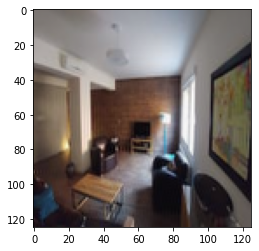

In [211]:
plt.imshow(x_sample_input_2)
plt.show()

In [212]:
x_sample_input_1.reshape(1,9)

array([[ 0.4967544 ,  0.46616087,  1.25920625,  0.90211903,  0.03609688,
         1.28037547, -0.58643816, -0.51152462,  1.1563357 ]])

In [214]:
y_sample_pred = np.exp(model.predict([x_sample_input_1.reshape(1,9), x_sample_input_2.reshape(1,125, 125, 3)])[0][0]) -1
y_sample_output = float(y_sample_output)

print("{:20}: {:.5}".format("Precio real", y_sample_output))
print("{:20}: {:.5}".format("Precio predicho", y_sample_pred))
print("{:20}: {:.5}".format("----------------", "-------"))
print("{:20}: {:.5}".format("Error", np.abs(y_sample_output - y_sample_pred)))

Precio real         : 120.0
Precio predicho     : 124.39
----------------    : -----
Error               : 4.3874
